In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time

# Generate synthetic data

First, we create a regular grid of observation points.

In [2]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

Then, we create a low-frequency noise by simulating deeper dipole sources

In [3]:
# deep_dipole_coordinates = (
#     [ 300,  750, 1200, 300, 1200, 1750],  # µm
#     [ 300, 1000, 1700, 1600, 300, 1000],  # µm
#     [-600, -600, -600, -600, -600, -600],  # µm
# )
# deep_dipole_moments = mg.angles_to_vector(
#     inclination=[-90, 90, -90, 90, 90, -90],
#     declination=[0, 0, 0, 0, 0, 0],
#     amplitude=[1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10],
# )

Now create the dipole model that will be used to generate the data.

In [4]:
sourcers1 = 50
sourcers2 = 150
sourcers3 = 9
np.random.seed(3)

dipole_coordinates = (
    np.concatenate([np.random.randint(0, 2000, sourcers1),np.random.randint(0, 2000, sourcers2),np.random.randint(0, 2000, sourcers3)]),  # µm
    np.concatenate([np.random.randint(750, 1250, sourcers1),np.random.randint(0, 2000, sourcers2),np.random.randint(0, 2000, sourcers3)]),  # µm
    np.concatenate([np.random.randint(-20, -1, sourcers1+sourcers2), np.random.randint(-60, -30, sourcers3)]),  # µm
)
dipole_moments = mg.angles_to_vector(
    inclination=np.concatenate([np.random.normal(35, 5, sourcers1),np.random.normal(0, 50, sourcers2), np.random.normal(0, 50, sourcers3)]),
    declination=np.concatenate([np.random.normal(340, 5, sourcers1),np.random.normal(0, 140, sourcers2),np.random.normal(0, 140, sourcers3)]),
    amplitude=np.concatenate([abs(np.random.normal(0, 100, sourcers1))*1.0E-16, abs(np.random.normal(0, 100, sourcers2))*1.0E-15, np.ones(sourcers3)*1.0e-11]),
)

# print(abs(np.random.normal(1.0E-14, 1.0E-12, sourcers)))
print(dipole_coordinates)

(array([1898, 1688, 1273, 1667,  952,  968,  256,  789, 1021,  659, 1738,
        875, 1017, 1705, 1674,  917, 1143, 1446,  480, 1684, 1964,  605,
       1447,  398, 1528, 1562,  337, 1498,  662,  834,  258, 1983, 1340,
        641, 1971,  858, 1605,  872,  622, 1633,  413, 1642, 1176,  507,
        830,  519, 1016, 1195, 1569,  379, 1359,  176, 1829, 1044,  862,
        561, 1429,  383, 1742, 1524, 1564, 1911, 1590, 1024,  704, 1001,
        274, 1396, 1983, 1701,  184, 1976, 1991,  165, 1789, 1710,  545,
        113, 1025, 1877,  117,  887, 1994, 1771, 1916,  996, 1635,  731,
       1936,  511,  848, 1696,  912, 1010,  274, 1867,  183,  864, 1247,
        141, 1445, 1438, 1584, 1981, 1313,  308,  497,  508,  754,    2,
       1180,   36,  858, 1768,  684,  176, 1851,  970,  182, 1520,  484,
       1627,  497,  277,  625, 1848, 1640,  295,  285, 1184, 1712, 1033,
       1057, 1519,  503,  444,  728, 1335,  267, 1236,  906,  368, 1744,
         76,  836, 1324,   44, 1019, 1299,  912,  

In [5]:
# bz_regional = mg.dipole_bz(coordinates, deep_dipole_coordinates, deep_dipole_moments)
bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
# data = vd.make_xarray_grid(coordinates, bz+bz_regional, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data = vd.make_xarray_grid(coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}


# Add some random noise to make it more realistic.
noise_std_dev = 50  # nT
data.bz.values += mg.gaussian_noise(noise_std_dev, data.bz.shape, seed=42)
# Add a positive shift to the data 
data.bz.values += 2000 # nT

data

<xarray.Dataset> Size: 16MB
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 8MB 2.01e+03 1.942e+03 ... 1.991e+03 1.978e+03

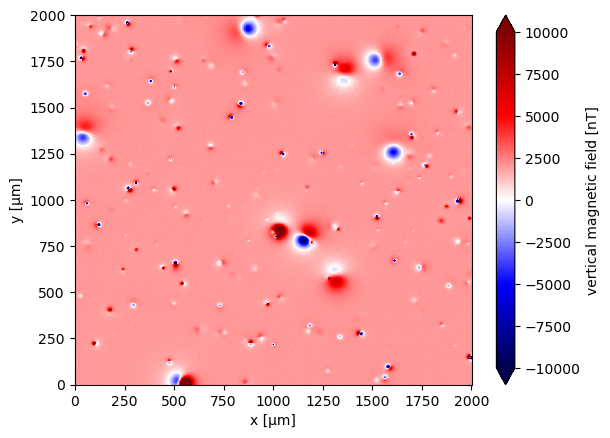

In [6]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

Add a polynomial shift to the data

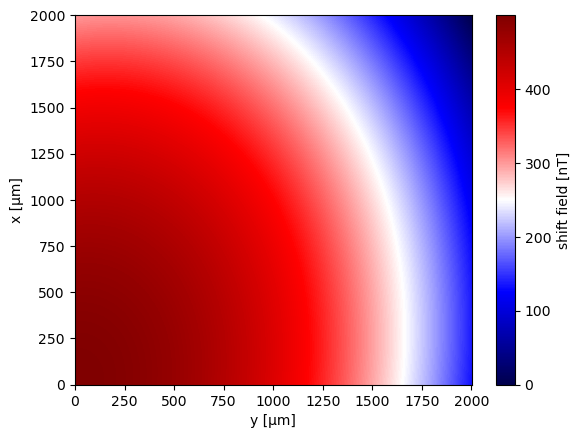

In [7]:
# a, b, c, d, e, f, g = 1, 2, -1, 3, -2, 1, 0.5
# a, b, c, d, e, f, g = 1.0, 0.5, 0.2, -1.0, 0.8, -2.0, 0.3
# pol = (a * data['x']**2 + b * data['y']**2 + c * data['x'] * data['y'] + d * data['x'] + e * data['y'] + f + g * data['y']**2)
# data['poly'] = (pol/pol.values.max())*2000


a, b, c, d, e, f, g = 3, 5, -1, 3, -5, 10, 0.5
pol = (a * data['x']**2 + b * data['y']**2 + c * data['x'] * data['y'] + d * data['x'] + e * data['y'] + f + g * data['y']**2)
data['poly'] = abs((pol/pol.values.max())-(pol/pol.values).max())*500

data.poly.attrs = {"long_name": "shift field", "units": "nT"}


# data.bz.values += data.poly.values 

data.poly.plot.pcolormesh(cmap="seismic")#, vmax=10000, vmin=-10000)

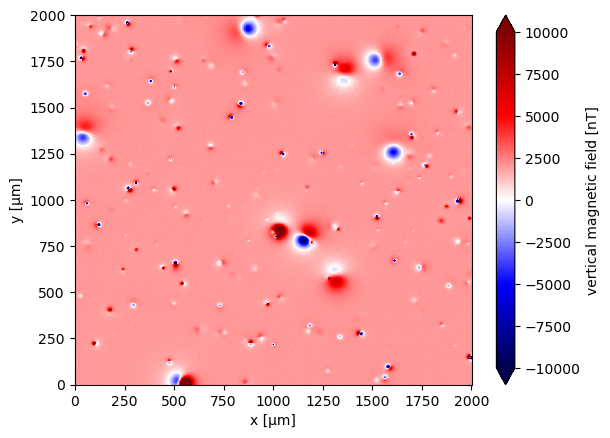

In [8]:
# median = np.median(data.bz.values)
# data.bz.values -= median

data_copy = data.copy(deep=True)
data_copy2 = data_copy.copy(deep=True)

data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Regional Separation

In [9]:
# regional = vd.Trend(degree=1).fit(coordinates, data.bz.values)
# data = data.assign(
#     regional_predicted=regional.predict((data.x, data.y)),
# )
# data.bz.values -= data.regional_predicted.values
# data


data_table = vd.grid_to_table(data)

regional = vd.Trend(degree=1).fit((data_table.x, data_table.y), data.bz.values.ravel())

shape = data.bz.shape
regional_predicted=regional.predict((data_table.x, data_table.y))
regional_predicted = np.reshape(regional_predicted, shape)


data = data.assign(regional_predicted=(("y", "x"), regional_predicted))
data.regional_predicted.attrs = {"long_name": "vertical magnetic field", "units": "nT"}

# data.bz.values -= data.regional_predicted.values

data

<xarray.Dataset> Size: 32MB
Dimensions:             (y: 1001, x: 1001)
Coordinates:
  * x                   (x) float64 8kB 0.0 2.0 4.0 ... 1.998e+03 2e+03
  * y                   (y) float64 8kB 0.0 2.0 4.0 ... 1.998e+03 2e+03
    z                   (y, x) float64 8MB 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
Data variables:
    bz                  (y, x) float64 8MB 2.01e+03 1.942e+03 ... 1.978e+03
    poly                (x, y) float64 8MB 500.0 500.0 500.0 ... 0.6662 0.0
    regional_predicted  (y, x) float64 8MB 2.004e+03 2.004e+03 ... 1.987e+03

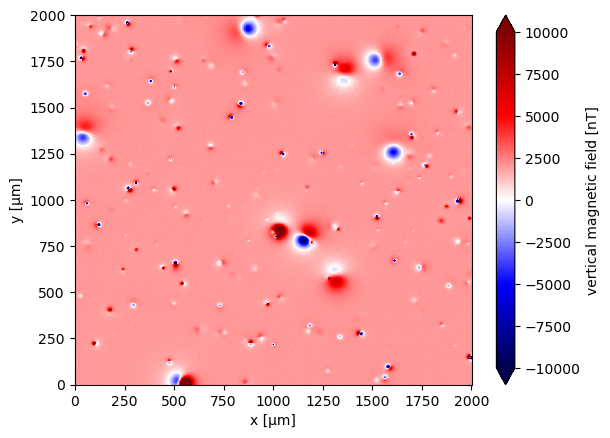

In [10]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [11]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 16MB
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 8MB 2.003e+03 2.003e+03 ... 2.003e+03 2.004e+03

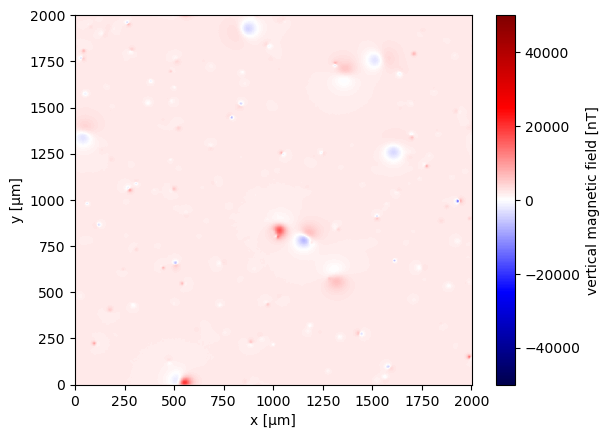

In [12]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [13]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 48MB
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 8MB 2.003e+03 2.003e+03 ... 2.003e+03 2.004e+03
    tga      (y, x) float64 8MB 1.099 1.678 2.137 1.91 ... 0.9689 0.6243 0.6904
    x_deriv  (y, x) float64 8MB 0.3437 0.4567 0.3554 ... -0.1826 0.1546 0.2989
    y_deriv  (y, x) float64 8MB -0.8328 -1.591 -1.993 ... 0.2153 0.01433 -0.4767
    z_deriv  (y, x) float64 8MB 0.6289 0.2731 -0.6867 ... 0.9269 0.6047 0.4002

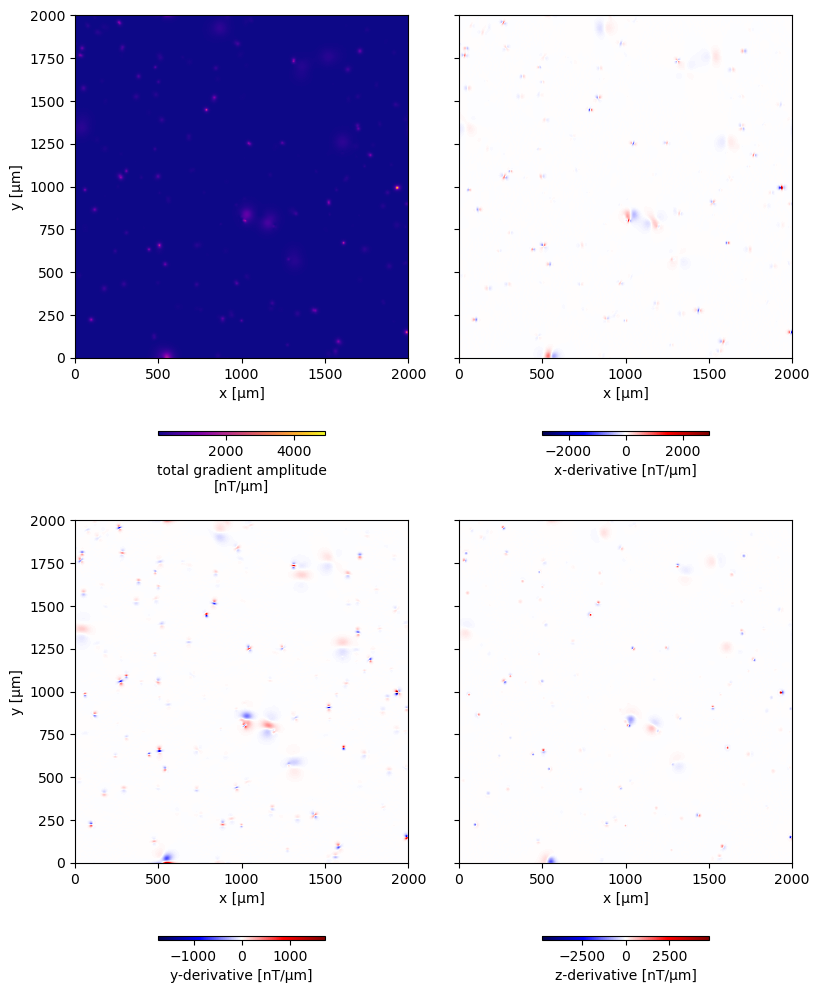

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [15]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

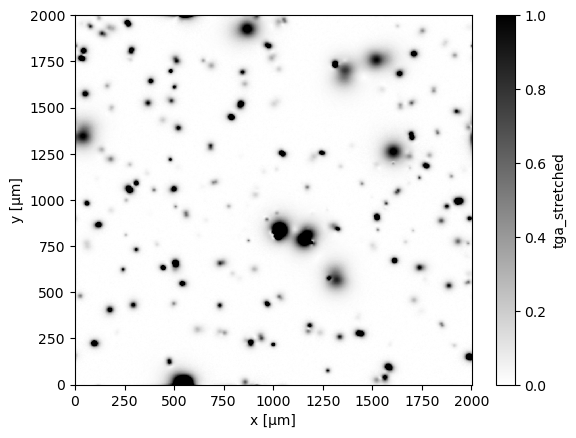

In [16]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [17]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 150],
    size_increment=1.0,
    threshold=0.09,
    overlap=0.3,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [18]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

120 potential sources detected within 2.462 seconds


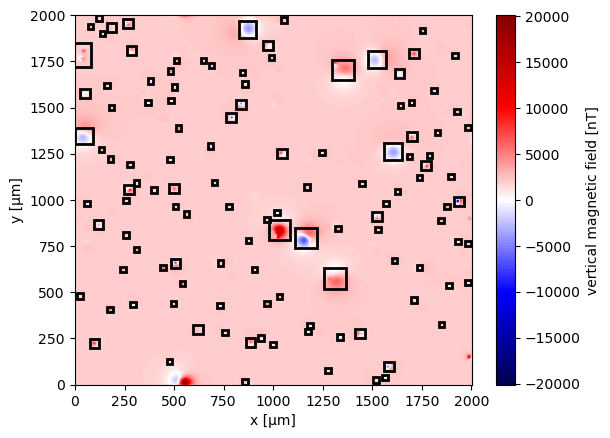

In [19]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [20]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False # position[2] > 0
    poor_fit = False
    
#     bad_euler = position[2] > 0
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

In [21]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

120 euler positions and dipole moments estimated within 1.3264 seconds


Compare the Euler Deconvolution estimated position on each window to the source true positions.

In [22]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions))[1]
z_difference = positions[2] - np.array(dipole_coordinates[2])[closest]
z_difference

array([  0.41368529,   0.31353258,   0.30784826,   0.48341981,
         0.068646  ,   0.4174982 ,   0.33988863,   0.41788662,
         0.47995685,   0.41354786,   0.42791439,   0.384965  ,
         0.54947074,   0.5611276 ,   0.36323229,   0.31411622,
         0.4918685 ,   0.32804366,   0.51201685,   0.40746819,
         0.4603393 ,   0.79118117,   0.50120884,   0.50321003,
         0.37909419,  12.88055042,   0.29123596,   0.3189213 ,
         0.2842069 ,   0.69317812,   3.01674381,   0.27702428,
        -1.14412067,   0.49828978,   0.53686709,   1.11974483,
        -0.05396323,   0.51073827,   0.52921056,   0.57471366,
        -0.79411526,   0.34094374,   0.83450386,   0.49280112,
         0.52001981,  -0.22637089,   0.54752987,   0.13242794,
         0.44792686,   0.50196991,   0.61720281,   0.60222813,
         0.4740035 ,   0.47005493,   0.48518335,   0.51221674,
         0.50003738,   0.43628458,   9.60104189,   0.33037544,
         0.38744035,   0.81053368,   0.4619445 ,   0.54

In [23]:
# Misfits alculation
direction_misfit = []
magnetic_moment_misfit = []

for estimated, true in zip(estimated_dipole_moments, dipole_moments[closest]):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)

    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit.append(dir_misfit)
    magnetic_moment_misfit.append(magm_mom_misfit)

/tmp/ipykernel_208348/3758845858.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dir_misfit = float(np.degrees(mplstereonet.angular_distance(


# Iterative Euler deconvolution

In [24]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameters, obs_data, coordinates):
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    # de, dn = de_orig*mg.MICROMETER_TO_METER, dn_orig*mg.MICROMETER_TO_METER
    de, dn, du = parameters[0], parameters[1], parameters[2]
    mx, my, mz = parameters[3], parameters[4], parameters[5]
    
    e, n, u = coordinates[0], coordinates[1], coordinates[2]
    # print(mx)
    # bz = np.zeros(np.shape(obs_data))
    # for i in numba.prange(e.size):
    distance = choclo.utils.distance_cartesian(
            e,
            n,
            u,
            de,
            dn,
            du,
        )

    bz = constant *(mx*choclo.point.kernel_eu(
            easting_p=e,
            northing_p=n,
            upward_p=u,
            easting_q=de,
            northing_q=dn,
            upward_q=du,
            distance=distance)+
        
          my*choclo.point.kernel_nu(
            easting_p=e,
            northing_p=n,
            upward_p=u,
            easting_q=de,
            northing_q=dn,
            upward_q=du,
            distance=distance)+

          mz*choclo.point.kernel_uu(
            easting_p=e,
            northing_p=n,
            upward_p=u,
            easting_q=de,
            northing_q=dn,
            upward_q=du,
            distance=distance)
                   )
    
    Res = np.linalg.norm( (obs_data)-bz.ravel() )
    return(Res)

In [25]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameter, obs_data, coordinates, amplitude, x_0, y_0, z_0):
    bz = mg.dipole_bz(coordinates, 
                      ([parameter[0]*x_0], [parameter[1]*y_0], [parameter[2]*z_0]),
                     np.array([parameter[3], parameter[4], parameter[5]])*amplitude
                     )
                   
    
    Res = np.linalg.norm(obs_data-bz.ravel())
    # print(Res)
    return(Res)

In [26]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()


x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []
calculated_SNR_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

#################################
for window in rich.progress.track(np.array(windows), total = len(np.array(windows))):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')

    estimated_dipole_moments_itr_euler.append(moment)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)
    calculated_SNR_itr_euler = np.append(calculated_SNR_itr_euler, SNR)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

piorou

In [27]:
np.sum(estimated_dipole_moments_itr_euler, axis=0)

array([ 9.14508673e-12,  8.73730970e-12, -1.85544523e-11])

In [28]:
minimization

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 258.0687872321044
             x: [ 1.002e+00  9.917e-01  9.564e-01 -2.517e-01  5.658e-01
                 -3.386e-01]
           nit: 653
          nfev: 1047
 final_simplex: (array([[ 1.002e+00,  9.917e-01, ...,  5.658e-01,
                        -3.386e-01],
                       [ 1.002e+00,  9.917e-01, ...,  5.658e-01,
                        -3.386e-01],
                       ...,
                       [ 1.002e+00,  9.917e-01, ...,  5.658e-01,
                        -3.386e-01],
                       [ 1.002e+00,  9.917e-01, ...,  5.658e-01,
                        -3.386e-01]]), array([ 2.581e+02,  2.581e+02,  2.581e+02,  2.581e+02,
                        2.581e+02,  2.581e+02,  2.581e+02]))

In [29]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 44.0666 seconds


In [30]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

x      y     z           bz    z_deriv
0  1912.0  970.0  10.0  1797.070249 -21.399349
1  1914.0  970.0  10.0  1780.746365 -26.508039
2  1916.0  970.0  10.0  1761.390584 -29.393347
3  1918.0  970.0  10.0  1741.776713 -31.758802
4  1920.0  970.0  10.0  1725.895463 -35.073366

In [31]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])
print(positions_itr[:, 2])

[ 835.9750543  1516.98258327   -5.98701846]


In [32]:
# indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# indexes
# euler_r2_itr_cond

Output()

Output()

[1675.64409975913, 1724.35590024087, 1321.64409975913, 1370.35590024087]

21

[977.002805907713, 1086.997194092287, 783.002805907713, 892.997194092287]

25

[861.6440997591301, 910.3559002408699, 203.64409975913003, 252.35590024086997]

28

[949.6440997591301, 998.3559002408699, 1811.64409975913, 1860.35590024087]

29

[1111.002805907713, 1220.997194092287, 737.002805907713, 846.997194092287]

30

[1171.857864376269, 1200.142135623731, 305.85786437626905, 334.14213562373095]

35

[1613.64409975913, 1662.35590024087, 1659.64409975913, 1708.35590024087]

36

[1311.857864376269, 1340.142135623731, 829.857864376269, 858.142135623731]

40

[1257.002805907713, 1366.997194092287, 519.002805907713, 628.997194092287]

58

[1613.857864376269, 1642.142135623731, 1031.857864376269, 1060.142135623731]

61

[-0.7834294751480115, 88.78342947514801, 1301.216570524852, 1390.783429475148]

64

[1297.002805907713, 1406.997194092287, 1649.002805907713, 1758.997194092287]

65

[-49.21095870942605, 81.21095870942605, 1720.789041290574, 1851.210958709426]

73

[1041.857864376269, 1070.142135623731, 1959.857864376269, 1988.142135623731]

75

[1017.857864376269, 1046.142135623731, 461.85786437626905, 490.14213562373095]

78

[953.857864376269, 982.142135623731, 879.857864376269, 908.142135623731]

89

[741.857864376269, 770.142135623731, 267.85786437626905, 296.14213562373095]

96

[105.85786437626905, 134.14213562373095, 1971.857864376269, 2000.142135623731]

106

[1969.857864376269, 1998.142135623731, 751.857864376269, 780.142135623731]

107

[1003.857864376269, 1032.142135623731, 915.857864376269, 944.142135623731]

119

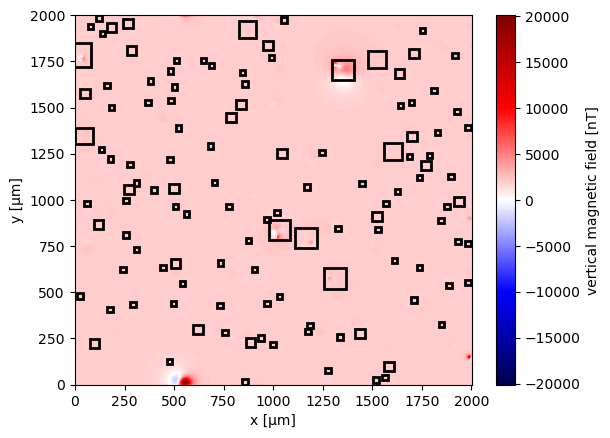

In [33]:
## EULER ENHANCEMENT SECOND STEP
warnings.filterwarnings("ignore")
data_copy = data.copy(deep=True)
euler_r2_itr_cond = calculated_r2_itr_euler>=0.999

zc_concat_temp = list()
xc_concat_temp = list()
yc_concat_temp = list()

estimated_dipole_moments_itr_euler_temp = list()

indexes = np.where(np.array(euler_r2_itr_cond))[0]
# SOURCES WITH R2 >= 0.99 ARE NOT ENHANCED, WE CALCULATE THEIR ANOMALY AND REMOVE THEM FROM THE DATA SET
# for index, window in enumerate(rich.progress.track(np.array(windows)[euler_r2_itr_cond], total=len(np.array(windows)[euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    position = positions_itr[:, index]
    estimated_dipole_moments_itr_euler_temp.append(estimated_dipole_moments_itr_euler[index])
    xc_concat_temp = np.append(xc_concat_temp, position[0])
    yc_concat_temp = np.append(yc_concat_temp, position[1])
    zc_concat_temp = np.append(zc_concat_temp, position[2])  

    
# remove all signals 
position_temp = np.array([xc_concat_temp, yc_concat_temp, zc_concat_temp])
discard = mg.dipole_bz(coordinates, position_temp, estimated_dipole_moments_itr_euler_temp)
data_copy.bz.values -= discard

data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))

###################################################

# ax = plt.subplot(111)
# data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
# for window in windows:
#     rect = matplotlib.patches.Rectangle(
#         xy=[window[0], window[2]],
#         width=window[1] - window[0],
#         height=window[3] - window[2],
#         edgecolor="k",
#         fill=False,
#         linewidth=2,
#     )
#     ax.add_patch(rect)   

##################################################

# SOURCES WITH R2 <= 0.99 ARE ENHANCED
indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# for index, window in enumerate(rich.progress.track(np.array(windows)[~euler_r2_itr_cond], total=len(np.array(windows)[~euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    print(window)
    print(index)
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)



    ## SCIPY MINIMIZATION
    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
        
        if r2 >= calculated_r2_itr_euler[index]:
            estimated_dipole_moments_itr_euler[index] = moment
            positions_itr[:, index] = position
    
    # # store the results with the itr Euler (without interfering sources)
    # print(estimated_dipole_moments_itr_euler[index])
    # print(positions_itr[:, index])
    # estimated_dipole_moments_itr_euler[index] = moment
    # positions_itr[:, index] = position

    # print(moment)
    # print(position)
    # print()
    # #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard

    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))



ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   


In [34]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions_itr))[1]
z_difference_itr = positions_itr[2] - np.array(dipole_coordinates[2])[closest]
z_difference_itr
# euler_r2_itr_cond


array([-1.52153468e-02, -2.21208782e-02,  1.29815410e-02,  9.64046949e-02,
       -3.38423715e-01, -6.58996725e-03,  3.67826247e-02, -5.17238862e-03,
        1.23491104e-01,  9.74854377e-03,  1.48290333e-02,  1.19694753e-01,
        1.45897382e-01,  1.68831917e-01,  9.35912679e-02,  2.21197043e-02,
        2.62568200e-02, -1.88222246e-04,  1.75964048e-01,  5.45409499e-02,
        1.14943501e-01,  3.65156711e-01,  1.16457616e-01,  1.35306579e-01,
       -2.86074437e-02,  3.21762241e+00, -2.22152444e-02,  5.28186637e-02,
        2.60721640e-01,  2.07651888e-02,  7.44016920e-01,  8.02252752e-02,
       -9.08264574e-01,  2.19739609e-01,  1.74250715e-01,  1.63357312e-01,
        4.38793153e-03,  1.62708359e-01,  1.82225236e-01,  2.23261643e-01,
       -6.79511933e-01,  2.07435207e-01,  2.92459194e-01,  1.67891423e-01,
        1.52341523e-01, -4.93624176e-01,  2.19505816e-01,  1.16529568e-01,
        1.67576136e-01,  1.36358029e-01,  2.72041749e-01,  2.27672704e-01,
        1.61342308e-01,  

# Comparison plots

## Euler comparison

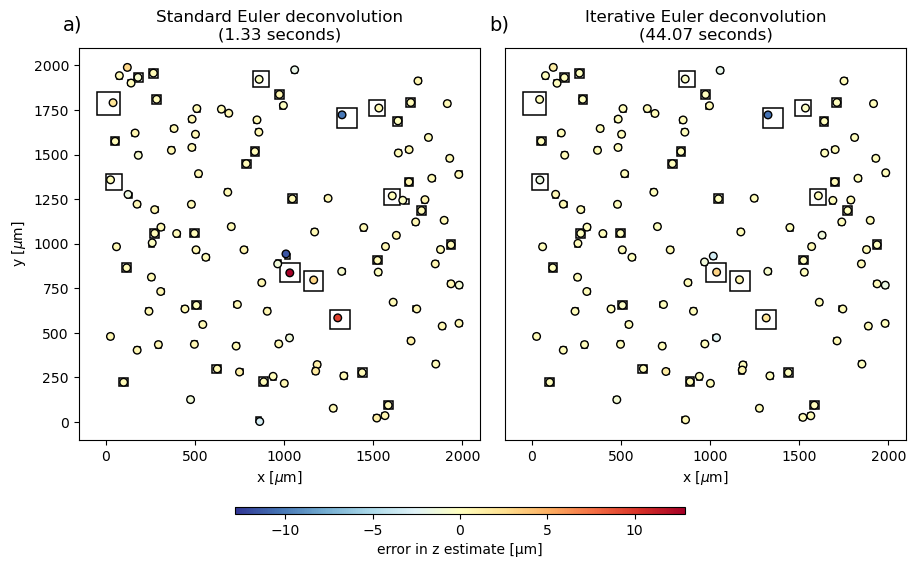

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

scale = vd.maxabs((z_difference, z_difference_itr))

ax = axes[0]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

ax = axes[1]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions_itr[:2], c=z_difference_itr, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

titles = ([r'Standard Euler deconvolution'   +'\n'+ f'({round(inversion_time, 2)} seconds)', 
           r'Iterative Euler deconvolution' +'\n'+ f'({round(itr_euler_time, 2)} seconds)'])
for ax, letter, title in zip(axes, "a b".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.set_xlabel(r"x [$\mu$m]")

axes[1].set_yticks([])
axes[0].set_ylabel(r"y [$\mu$m]")
plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.25, 0.2, 0.5, 0.0075]))


plt.show()

## Directions and Dipole Moments comparions

### Iterative Euler (withou interf. sources)

In [36]:
# Misfits alculation
direction_misfit_itr_euler = []
magnetic_moment_misfit_itr_euler = []

for estimated, true in zip(estimated_dipole_moments_itr_euler, dipole_moments[closest]):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)

    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit_itr_euler.append(dir_misfit)
    magnetic_moment_misfit_itr_euler.append(magm_mom_misfit)

In [37]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

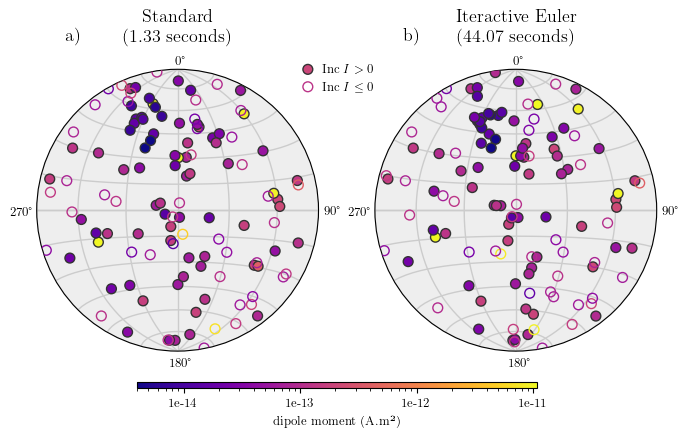

In [38]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(8, 4))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]

    
    vmin = np.min([np.min(estimated1),np.min(estimated2)])
    vmax = np.max([np.max(estimated1),np.max(estimated2)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
    ## STANDARD METHOD
    ax = fig.add_subplot(1, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    ## ITERACTIVE METHOD
    ax = fig.add_subplot(1, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    ######
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)']) 
 

    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()


# Paper's figures 

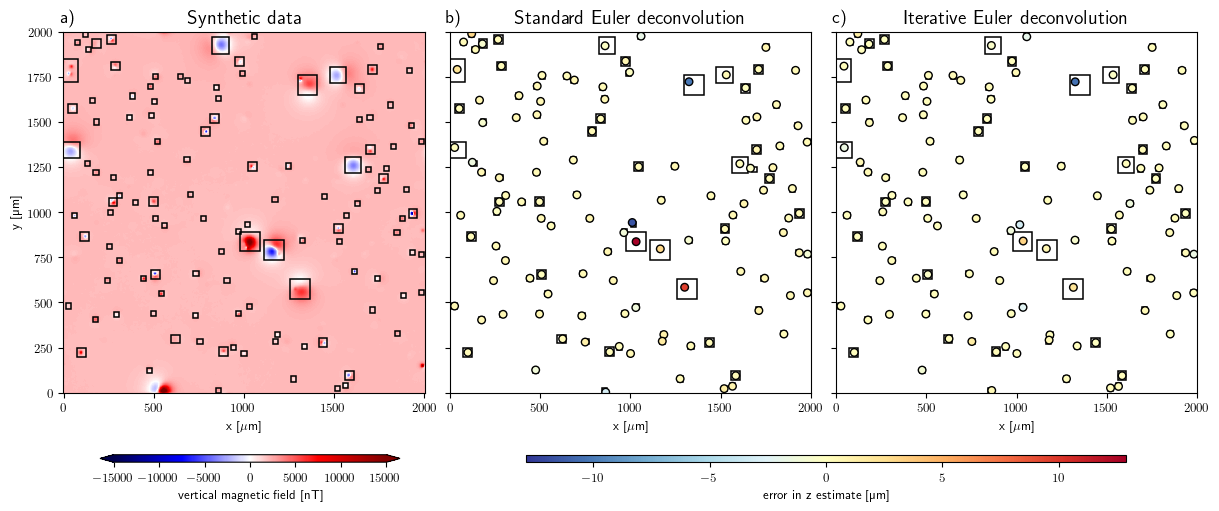

In [39]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((z_difference, z_difference_itr))

    ax = axes[1]
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

    ax = axes[2]
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=z_difference_itr, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

    titles = ([r'Synthetic data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, -0.00, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.43, -0.00, 0.5, 0.015]))
    fig.savefig(fig_dir / "euler-comparion-synthetic.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


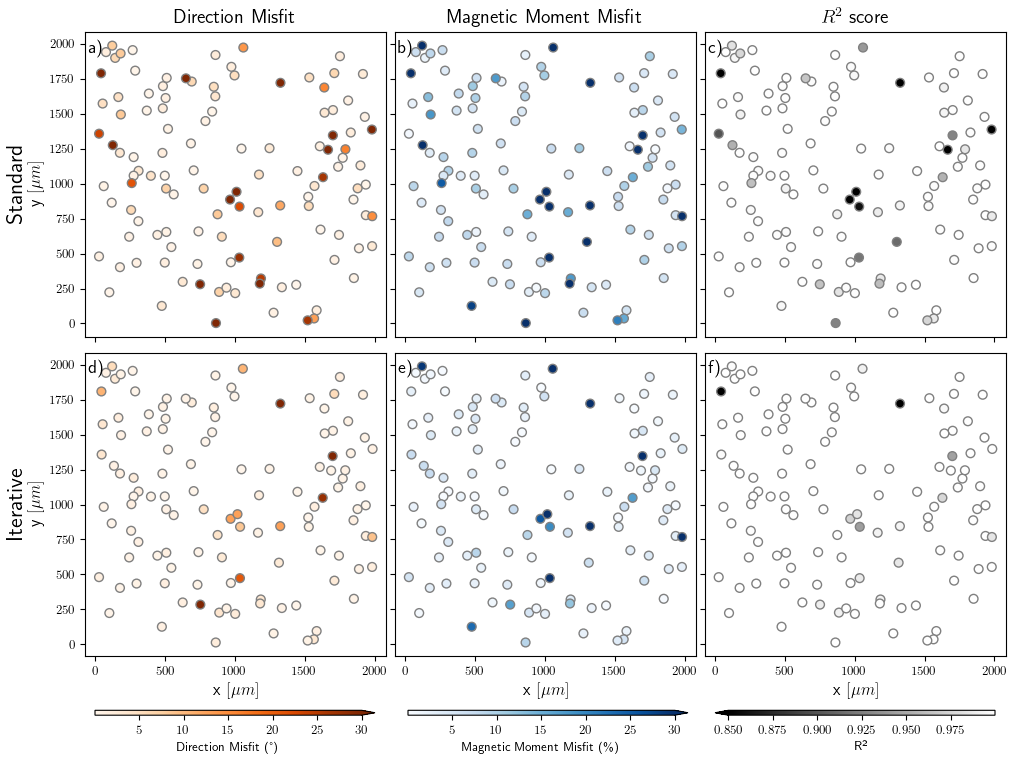

In [40]:
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 3, figsize=(10, 7), sharey="row", sharex='col')
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.9)
    
    scale = 30
    ax = axes[0]
    # ax.set_title("Standard", fontsize=16)    
    ax.set_title("Direction Misfit", fontsize=14)    
    tmp = ax.scatter(*positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')

    ax = axes[3]
    # ax.set_title("Iteractive", fontsize=16)
    tmp = ax.scatter(*positions_itr[:2], c=direction_misfit_itr_euler, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label="Direction Misfit (°)", cax=fig.add_axes([0.085, -0.015, 0.28, 0.007]), extend='max')



    
    scale = 30
    ax = axes[1] 
    ax.set_title("Magnetic Moment Misfit", fontsize=14) 
    tmp = ax.scatter(*positions[:2], c=magnetic_moment_misfit, s=40, cmap="Blues", vmax=scale, edgecolor='gray')

    ax = axes[4] 
    tmp = ax.scatter(*positions_itr[:2], c=magnetic_moment_misfit_itr_euler, s=40, cmap="Blues", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label=r"Magnetic Moment Misfit (\%)", cax=fig.add_axes([0.398, -0.015, 0.28, 0.007]), extend='max')

    
    scale = 0.85
    ax = axes[2] 
    ax.set_title("$R^2$ score", fontsize=14) 
    tmp = ax.scatter(*positions[:2], c=calculated_r2, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    
    ax = axes[5]
    tmp = ax.scatter(*positions_itr[:2], c=calculated_r2_itr_euler, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label="R²", cax=fig.add_axes([0.705, -0.015, 0.28, 0.007]), extend='min')

    for ax, letter in zip(axes, "a b c d e f g h i j k l".split()):
        ax.text(0.01, 0.93, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")

    axes[0].set_ylabel(r'\fontsize{16}{0}\selectfont{Standard}'+'\n'+r'y $[\mu m]$', fontsize=12)
    axes[3].set_ylabel(r'\fontsize{16}{0}\selectfont{Iterative}'+'\n'+r'y $[\mu m]$', fontsize=12)
    
    axes[3].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[4].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[5].set_xlabel(r'x $[\mu m]$', fontsize=12)

    plt.tight_layout(pad=0, h_pad=0.0, w_pad=0.0)
    fig.savefig(fig_dir / "inversion-comparion-synthetic.png", dpi=300, facecolor='w', bbox_inches='tight')
plt.show()   

In [41]:
data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


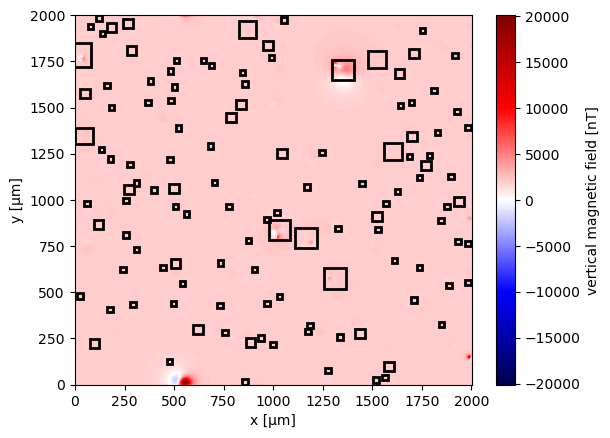

In [42]:
ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

In [43]:
data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
data_up_copy

<xarray.Dataset> Size: 48MB
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 8MB 2.002e+03 2.003e+03 ... 2.001e+03 2.002e+03
    tga      (y, x) float64 8MB 1.114 1.677 2.147 1.905 ... 1.314 1.024 0.9143
    x_deriv  (y, x) float64 8MB 0.6039 0.6927 0.5477 ... 0.0162 0.426 0.6111
    y_deriv  (y, x) float64 8MB -0.6958 -1.509 -1.95 ... 0.5009 0.2625 -0.2848
    z_deriv  (y, x) float64 8MB 0.6259 0.2383 -0.7111 ... 1.215 0.8929 0.6175

In [44]:
stretched = skimage.exposure.rescale_intensity(
    data_up_copy.tga, 
    in_range=tuple(np.percentile(data_up_copy.tga, (1, 99))),
)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

In [101]:
start_detection_time = time.perf_counter()

windows_new = mg.detect_anomalies(
    data_up_copy.tga_stretched, 
    size_range=[20,150],
    size_increment=1.3,
    threshold=0.02,
    overlap=0.0,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [102]:
detection_time = end_detection_time-start_detection_time
print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

120 potential sources detected within 2.3081 seconds


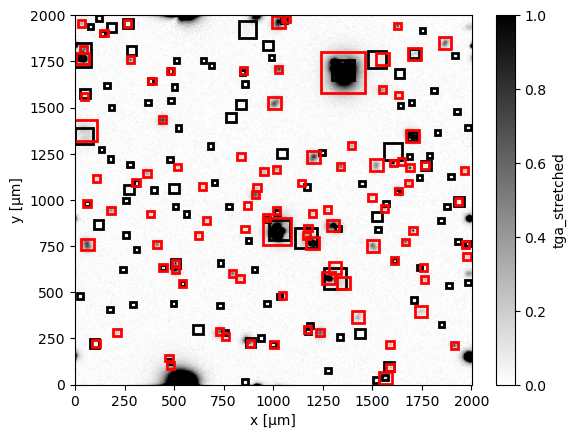

In [103]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

for window in windows_new:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [104]:
def intersects(window1, window2):
    # Verifica se há sobreposição horizontal
    horizontal_overlap = (window1[0] <= window2[1]) and (window2[0] <= window1[1])
    # Verifica se há sobreposição vertical
    vertical_overlap = (window1[2] <= window2[3]) and (window2[2] <= window1[3])
    return horizontal_overlap and vertical_overlap
    


# Remove overlapping windows
non_overlapping_windows = np.copy(windows_new)

for window in windows:
    non_overlapping_windows = [nw for nw in non_overlapping_windows if not intersects(nw, window)]

print("Non-overlapping windows:")
for window in non_overlapping_windows:
    print(window)

Non-overlapping windows:
[ 423.61522369  460.38477631 1415.61522369 1452.38477631]
[ 30.33732969  93.66267031 726.33732969 789.66267031]
[1009.61522369 1046.38477631 1689.61522369 1726.38477631]
[1671.61522369 1708.38477631 1155.61522369 1192.38477631]
[1687.61522369 1724.38477631  815.61522369  852.38477631]
[1895.61522369 1932.38477631  193.61522369  230.38477631]
[ 891.61522369  928.38477631 1009.61522369 1046.38477631]
[ 976.33732969 1039.66267031 1492.33732969 1555.66267031]
[1217.61522369 1254.38477631  263.61522369  300.38477631]
[1609.61522369 1646.38477631 1923.61522369 1960.38477631]
[1321.61522369 1358.38477631 1163.61522369 1200.38477631]
[1836.33732969 1899.66267031 1818.33732969 1881.66267031]
[1649.61522369 1686.38477631  753.61522369  790.38477631]
[ 261.61522369  298.38477631 1741.61522369 1778.38477631]
[1472.33732969 1535.66267031  718.33732969  781.66267031]
[775.61522369 812.38477631 583.61522369 620.38477631]
[395.61522369 432.38477631 741.61522369 778.38477631]
[

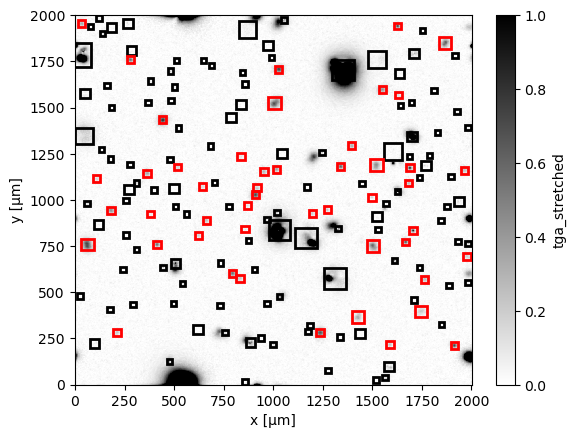

In [105]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [106]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

data_copy_2 = data_copy.copy(deep=True)
data_up_copy_2 = data_up_copy.copy(deep=True)

positions_itr_enhanced = list(np.copy(positions_itr))
estimated_dipole_moments_itr_euler_enhanced = list(np.copy(estimated_dipole_moments_itr_euler))
windows_enhanced = list(np.copy(windows))
calculated_r2_itr_euler_enhanced = list(np.copy(calculated_r2_itr_euler))

#################################
for window in rich.progress.track(np.array(non_overlapping_windows), total = len(np.array(non_overlapping_windows))):
    anomaly = data_up_copy_2.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')


    windows_enhanced.append(window)
    estimated_dipole_moments_itr_euler_enhanced.append(moment)
    for i in range(3):
        positions_itr_enhanced[i]=np.append(positions_itr_enhanced[i], position[i])
    calculated_r2_itr_euler_enhanced.append(r2)
    # estimated_dipole_moments_itr_euler.append(moment)
    print(position)
    print(moment)
    print(mg.vector_to_angles(moment))
    print(r2)
    print()
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy_2.bz.values -= discard
    
#     print(discard.max())
    data_up_copy_2 = (
                hm.upward_continuation(data_copy_2.bz, height_difference)
                .assign_attrs(data_copy_2.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy_2.x, y=data_copy_2.y)
                .assign_coords(z=data_copy_2.z + height_difference)
                   )
    
    
    data_up_copy_2 = data_up_copy_2.assign(mg.data_gradients(data_up_copy_2.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

[ 440.82299345 1429.30766366  -19.31276742]

[1.89223031e-14 4.30686632e-14 4.75410969e-14]

(-45.30224842938529, 23.718381161919595, 6.688138158728215e-14)

0.9994366619875662

[ 61.74863316 756.85202096 -19.83409176]

[ 2.04626900e-14 -1.01504393e-13 -3.15757152e-15]

(1.7466509721994572, 168.60227039365026, 1.0359456402803792e-13)

0.9997500716863484

[1025.10640281 1708.64421746  -16.28533082]

[2.47205287e-14 2.49735627e-16 3.00181749e-14]

(-50.52647079780987, 89.4211972216744, 3.888775810367436e-14)

0.9995400805901494

[1688.38785554 1176.05459873   -4.66566265]

[-1.38712014e-15  3.70466659e-15 -2.64514722e-15]

(33.76942697412802, -20.527161241560137, 4.758724685648307e-15)

0.9971512180585741

[1705.02829991  836.08110806   -3.1179233 ]

[-9.44715211e-16  2.50527657e-15 -1.80038460e-15]

(33.91758253749492, -20.66096707872205, 3.2264968975570635e-15)

0.9972509722329089

[1911.04081055  213.03072466   -8.36853978]

[-8.50312208e-15  2.86923934e-15 -4.98675514e-15]

(29.060011772173258, -71.3538752169384, 1.0266613183213374e-14)

0.9972591691973655

[ 911.23584858 1028.319086    -18.33147026]

[ 7.91128721e-15  3.78973154e-15 -4.13611804e-14]

(78.02577455571613, 64.40425394603308, 4.2281175157898715e-14)

0.9975026010670245

[1009.96118828 1526.08177051  -19.95943416]

[ 6.28178385e-14  6.07255852e-14 -1.78343646e-14]

(11.536864848789724, 45.97023233964964, 8.917254117576865e-14)

0.9997282300826115

[1235.74891855  277.05989513  -19.69608555]

[1.15222992e-14 4.22777554e-14 4.05003568e-14]

(-42.745614806460914, 15.245029856111458, 5.966951389057344e-14)

0.9993547191671913

[1626.84737365 1944.39298701   -7.53958575]

[ 1.02035014e-15 -5.03028366e-15  5.02971191e-15]

(-44.4192313305885, 168.53361077306576, 7.186297374510741e-15)

0.9979733843865297

[1339.67297548 1184.76468354   -9.4357199 ]

[-1.59161670e-15  8.02333700e-15 -6.64159382e-15]

(39.075302087217096, -11.220292120408308, 1.0536505528653532e-14)

0.9983855384399943

[1867.03151602 1849.18492221  -13.67195459]

[-1.64564739e-14 -2.83022213e-14 -2.15023971e-15]

(3.757707713924169, -149.8239168625512, 3.2809370516773396e-14)

0.9992044171413446

[1665.99969832  775.77844308  -10.43551609]

[-4.71884697e-15  7.15553671e-15 -7.43469056e-15]

(40.93776541954128, -33.403570626232366, 1.134653454096744e-14)

0.9919367497480382

[ 276.86213691 1761.9405504    -7.98178977]

[ 8.26722990e-15 -4.97793679e-15  1.69684863e-15]

(-9.972661504308794, 121.05335484056657, 9.798277409489324e-15)

0.9977966879520052

[1505.09611094  747.79193036  -17.13917784]

[ 2.08968250e-14 -4.42275764e-14 -9.39422969e-15]

(10.871231391611603, 154.71001208851908, 4.98097115446094e-14)

0.9991005109214508

[794.66826972 605.21231824 -12.85634623]

[ 1.47596211e-15 -1.31733151e-14  1.13435257e-14]

(-40.5550694547782, 173.60713863228352, 1.7446783893156763e-14)

0.9977232077274591

[412.74633249 763.10200949  -9.2691333 ]

[-4.02956462e-15  9.04473823e-15 -3.90769172e-15]

(21.536498313948226, -24.013679066831518, 1.0644939420228446e-14)

0.998959694955832

[1519.09391643 1183.95493664  -15.46676109]

[5.05264487e-15 3.19304880e-14 5.54427346e-15]

(-9.731656471269394, 8.991864296099594, 3.279975993618344e-14)

0.9987579301719661

[182.42723298 944.80238727 -17.44303555]

[-7.25561828e-16 -3.18119026e-15  2.28047654e-14]

(-81.85743860534134, -167.15182933508126, 2.3037007953476286e-14)

0.9976440654320522

[1555.04442167 1600.46474678  -19.39515093]

[-2.57117035e-14 -1.40634685e-14  2.27655438e-14]

(-37.840340472550196, -118.67723006040953, 3.710987511367098e-14)

0.9989006532599979

[1016.28118305 1170.12195328   -7.97959031]

[-1.13506393e-15  4.34515678e-15 -2.82767192e-15]

(32.195989046179356, -14.639943911159277, 5.307022334777943e-15)

0.9936551066361682

[ 362.80955007 1149.04290564  -13.39135837]

[ 1.85066341e-16 -1.26297515e-14  6.35312935e-15]

(-26.70124607851834, 179.16049326534628, 1.4138851597887543e-14)

0.9972949017030711

[  35.41462683 1959.16227587  -17.0716057 ]

[ 1.92263080e-15  1.51601833e-14 -1.35689120e-14]

(41.602645721429404, 7.2277281197581384, 2.0436316650170853e-14)

0.9983539944929873

[1395.65339314 1292.1459166   -15.17982959]

[-2.91392697e-15 -8.01307540e-15 -1.07910029e-14]

(51.68617250774849, -160.0163796187908, 1.3753039318973493e-14)

0.9950436979638462

[1428.52884333  367.65068815  -15.98228558]

[-8.79038789e-15 -1.98152512e-14  6.88769802e-15]

(-17.626848833972495, -156.07709871888514, 2.2745449773058374e-14)

0.9962153285006116

[1684.36558379 1093.67148279   -9.47342748]

[-8.12689726e-16  3.30352677e-15 -3.23566862e-15]

(43.56435731524632, -13.820701597092192, 4.695029838844823e-15)

0.9914484244437227

[ 951.23849313 1157.58605886  -13.62081048]

[-4.81752644e-15  9.34005817e-15 -5.52287465e-15]

(27.722955571108173, -27.284317541794376, 1.1872126688110274e-14)

0.9974428796333495

[1768.60864464  565.15653734  -16.08136922]

[ 6.74857879e-15 -1.09397294e-14 -8.09888176e-15]

(32.214015446187766, 148.33009623079656, 1.5192527103873795e-14)

0.9918667833334661

[658.37310513 893.37729382 -13.59392114]

[-3.39964436e-15  4.91796410e-15 -6.26751865e-15]

(46.351391787416574, -34.65496831852841, 8.66174017006462e-15)

0.9944273724274362

[1589.56570727  220.01822071   -7.99364549]

[-9.62511992e-16 -4.00604395e-15  5.29128358e-16]

(-7.318301662216602, -166.48991324908755, 4.153889050774752e-15)

0.9954752909515004

[1964.00509637 1167.12350024  -18.36150978]

[-4.96931613e-15  1.83932260e-14 -8.55639234e-15]

(24.184424973882003, -15.118706205212066, 2.088580176774843e-14)

0.9951872449091236

[211.09665715 281.70199735  -9.43963576]

[2.47632485e-15 4.28814386e-15 1.09469601e-15]

(-12.465889448206205, 30.005649900294856, 5.071362918836593e-15)

0.9918192487709167

[1742.36893367  394.09255412  -19.41731377]

[2.04149127e-14 1.43142382e-14 5.71077733e-15]

(-12.900665533684027, 54.96317583281779, 2.5578879036969307e-14)

0.9955098202811058

[1272.55882721  949.15747399   -4.16916638]

[-5.16362711e-16  9.00770105e-16 -7.20972951e-16]

(34.77589132913197, -29.823311462227483, 1.2640487434110331e-15)

0.9670615191999905

[828.5054783 579.5660094 -18.7017052]

[-6.08872510e-15  1.18639362e-14 -1.05998064e-14]

(38.480439751748136, -27.167479671949394, 1.703471308324824e-14)

0.9892212384980971

[1200.31757549  923.10278139  -12.55633928]

[ 1.33756831e-15 -2.65514356e-15 -4.25701363e-15]

(55.07021702007772, 153.2626354891452, 5.19240226916776e-15)

0.9420116502000135

[1975.61233044  698.54970726  -15.05160118]

[-6.10302395e-15  9.42088317e-15 -2.84481127e-15]

(14.221380454587276, -32.93591964178975, 1.1579848540310814e-14)

0.9944807917027945

[ 518.68992924 1181.31153936  -16.57964002]

[-4.07517858e-15  9.59402167e-15 -6.07191067e-15]

(30.221368989306463, -23.013954756733217, 1.2063184962132154e-14)

0.9882903811476866

[622.9253436  812.97632294 -14.66096717]

[-1.51736054e-15  7.27983896e-15 -3.66857611e-15]

(26.258693057929943, -11.773775820053524, 8.291977391250823e-15)

0.9897546110907429

[ 113.22025996 1116.19355601  -14.36723125]

[-2.81073040e-15 -1.28974523e-15  4.98906121e-15]

(-58.20692004802602, -114.64872400887398, 5.869785342070411e-15)

0.9892460335312371

[1498.93889368 1017.83270972   -2.12622117]

[-4.08161542e-17  4.73730112e-16 -2.94272208e-16]

(31.75287847148485, -4.924390889952159, 5.59180033341135e-16)

0.945284055581622

[ 640.8799361  1077.16101968  -14.96237143]

[-2.20927688e-15  6.30905178e-15 -3.58817263e-15]

(28.225790276473848, -19.299016083568173, 7.586832110934018e-15)

0.9849559476023615

[ 915.18614975 1066.04409387  -11.32989586]

[-2.82943246e-15  5.62011919e-15 -3.50148368e-15]

(29.09517293781506, -26.72283464100037, 7.200820491602625e-15)

0.9951418642779231

[1634.50364173 1565.37533893  -18.95343194]

[ 7.53600327e-15 -1.33378352e-14  1.49346415e-16]

(-0.5585436664373069, 150.5331401460404, 1.5320296888341294e-14)

0.9921237416618413

[ 837.42725659 1240.26133798  -14.49647078]

[-6.97546176e-16  3.66661500e-15 -2.84427879e-15]

(37.30941781187383, -10.771379206733226, 4.692606745823109e-15)

0.9585362490149788

piorou

[862.24200909 973.27562121 -11.63162903]

[-3.59872053e-15  1.89176195e-15  1.87754419e-17]

(-0.26459349366538837, -62.270160854913826, 4.065698615812142e-15)

0.7491466536317737

[378.34981704 924.22756863 -16.04100842]

[-8.78723990e-16 -2.00472271e-16 -3.71987921e-15]

(76.3800911313278, -102.85151882253521, 3.827511769584309e-15)

0.9487923235400841

[856.99761058 846.75009764 -16.8528675 ]

[-1.59586227e-15  3.51176094e-15 -2.54579621e-15]

(33.424162623905914, -24.438644514360085, 4.621722581585338e-15)

0.9501748414146195

In [107]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions_itr_enhanced))[1]
z_difference_itr_enhanced = positions_itr_enhanced[2] - np.array(dipole_coordinates[2])[closest]
z_difference_itr_enhanced

array([-1.52153468e-02, -2.21208782e-02,  1.29815410e-02,  9.64046949e-02,
       -3.38423715e-01, -6.58996725e-03,  3.67826247e-02, -5.17238862e-03,
        1.23491104e-01,  9.74854377e-03,  1.48290333e-02,  1.19694753e-01,
        1.45897382e-01,  1.68831917e-01,  9.35912679e-02,  2.21197043e-02,
        2.62568200e-02, -1.88222246e-04,  1.75964048e-01,  5.45409499e-02,
        1.14943501e-01,  3.65156711e-01,  1.16457616e-01,  1.35306579e-01,
       -2.86074437e-02,  3.21762241e+00, -2.22152444e-02,  5.28186637e-02,
        2.60721640e-01,  2.07651888e-02,  7.44016920e-01,  8.02252752e-02,
       -9.08264574e-01,  2.19739609e-01,  1.74250715e-01,  1.63357312e-01,
        4.38793153e-03,  1.62708359e-01,  1.82225236e-01,  2.23261643e-01,
       -6.79511933e-01,  2.07435207e-01,  2.92459194e-01,  1.67891423e-01,
        1.52341523e-01, -4.93624176e-01,  2.19505816e-01,  1.16529568e-01,
        1.67576136e-01,  1.36358029e-01,  2.72041749e-01,  2.27672704e-01,
        1.61342308e-01,  

In [108]:
# Misfits alculation
direction_misfit_itr_euler_enhanced = []
magnetic_moment_misfit_itr_euler_enhanced = []

for estimated, true in zip(estimated_dipole_moments_itr_euler_enhanced, dipole_moments[closest]):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)

    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit_itr_euler_enhanced.append(dir_misfit)
    magnetic_moment_misfit_itr_euler_enhanced.append(magm_mom_misfit)

/tmp/ipykernel_208348/2222737513.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dir_misfit = float(np.degrees(mplstereonet.angular_distance(


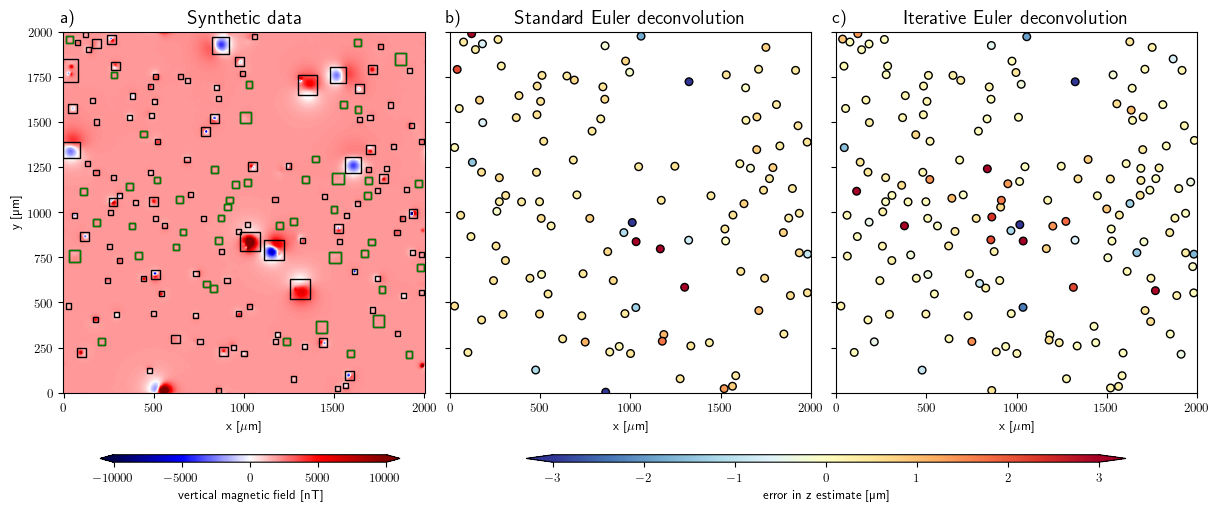

In [109]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-10000, vmax=10000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_enhanced:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)

    for window in non_overlapping_windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="g",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((z_difference))

    ax = axes[1]
    # for window in windows:
    #     rect = matplotlib.patches.Rectangle(
    #         xy=[window[0], window[2]],
    #         width=window[1] - window[0],
    #         height=window[3] - window[2],
    #         edgecolor="k",
    #         fill=False,
    #         linewidth=1.1,
    #     )
    #     ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-3, vmax=3, s=30, edgecolor='k')

    ax = axes[2]
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=z_difference_itr_enhanced, cmap="RdYlBu_r", vmin=-3, vmax=3, s=30, edgecolor='k')

    titles = ([r'Synthetic data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, -0.00, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs,  extend='both', label="error in z estimate [µm]", cax=fig.add_axes([0.43, -0.00, 0.5, 0.015]))
    fig.savefig(fig_dir / "euler-comparion-synthetic.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


/tmp/ipykernel_208348/389122893.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0, h_pad=0.0, w_pad=0.0)


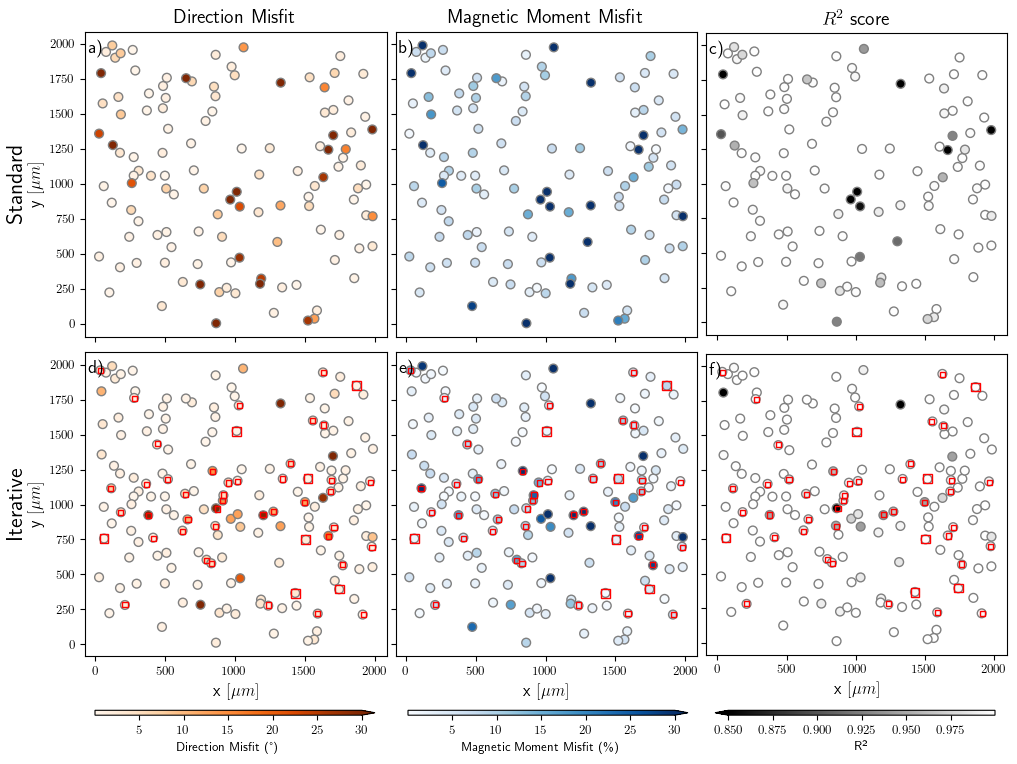

In [110]:
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 3, figsize=(10, 7), sharey="row", sharex='col')
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.9)
    
    scale = 30
    ax = axes[0]
    # ax.set_title("Standard", fontsize=16)    
    ax.set_title("Direction Misfit", fontsize=14)    
    tmp = ax.scatter(*positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')

    ax = axes[3]
    # ax.set_title("Iteractive", fontsize=16)
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=direction_misfit_itr_euler_enhanced, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label="Direction Misfit (°)", cax=fig.add_axes([0.085, -0.015, 0.28, 0.007]), extend='max')



    
    scale = 30
    ax = axes[1] 
    ax.set_title("Magnetic Moment Misfit", fontsize=14) 
    tmp = ax.scatter(*positions[:2], c=magnetic_moment_misfit, s=40, cmap="Blues", vmax=scale, edgecolor='gray')

    ax = axes[4] 
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=magnetic_moment_misfit_itr_euler_enhanced, s=40, cmap="Blues", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label=r"Magnetic Moment Misfit (\%)", cax=fig.add_axes([0.398, -0.015, 0.28, 0.007]), extend='max')

    
    scale = 0.85
    ax = axes[2] 
    ax.set_title("$R^2$ score", fontsize=14) 
    tmp = ax.scatter(*positions[:2], c=calculated_r2, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    
    ax = axes[5]
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=calculated_r2_itr_euler_enhanced, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label="R²", cax=fig.add_axes([0.705, -0.015, 0.28, 0.007]), extend='min')

    for ax, letter in zip(axes, "a b c d e f g h i j k l".split()):
        ax.text(0.01, 0.93, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")

        if ax == axes[-1] or ax == axes[-2] or ax == axes[-3]:
            for window in non_overlapping_windows:
                rect = matplotlib.patches.Rectangle(
                    xy=[window[0], window[2]],
                    width=window[1] - window[0],
                    height=window[3] - window[2],
                    edgecolor="r",
                    fill=False,
                    linewidth=1,
                )
                ax.add_patch(rect)

    axes[0].set_ylabel(r'\fontsize{16}{0}\selectfont{Standard}'+'\n'+r'y $[\mu m]$', fontsize=12)
    axes[3].set_ylabel(r'\fontsize{16}{0}\selectfont{Iterative}'+'\n'+r'y $[\mu m]$', fontsize=12)
    
    axes[3].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[4].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[5].set_xlabel(r'x $[\mu m]$', fontsize=12)

    plt.tight_layout(pad=0, h_pad=0.0, w_pad=0.0)
    # fig.savefig(fig_dir / "inversion-comparion-synthetic.png", dpi=300, facecolor='w', bbox_inches='tight')
plt.show()   

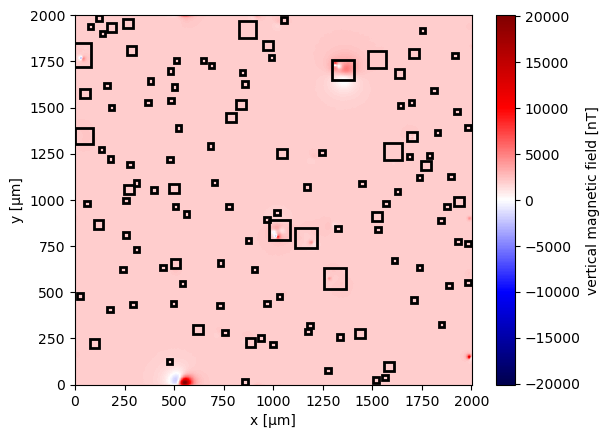

In [111]:
ax = plt.subplot(111)
data_up_copy_2.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:86: DeprecationWarning: invalid escape sequence '\m'
<>:114: DeprecationWarning: invalid escape sequence '\m'
<>:115: DeprecationWarning: invalid escape sequence '\m'
<>:195: DeprecationWarning: invalid escape sequence '\c'
<>:197: DeprecationWarning: invalid escape sequence '\c'
<>:199: DeprecationWarning: invalid escape sequence '\c'
<>:201: DeprecationWarning: invalid escape sequence '\c'
<>:203: DeprecationWarning: invalid escape sequence '\c'
<>:206: DeprecationWarning: invalid escape sequence '\g'
<>:207: DeprecationWarning: invalid escape sequence '\g'
<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:86: DeprecationWarning: invalid escape sequence '\m'
<>:114: DeprecationWarning: invalid escape sequence '\m'
<>:115: DeprecationWarning: invalid escape sequence '\m'
<>:195: DeprecationWarning: invalid e

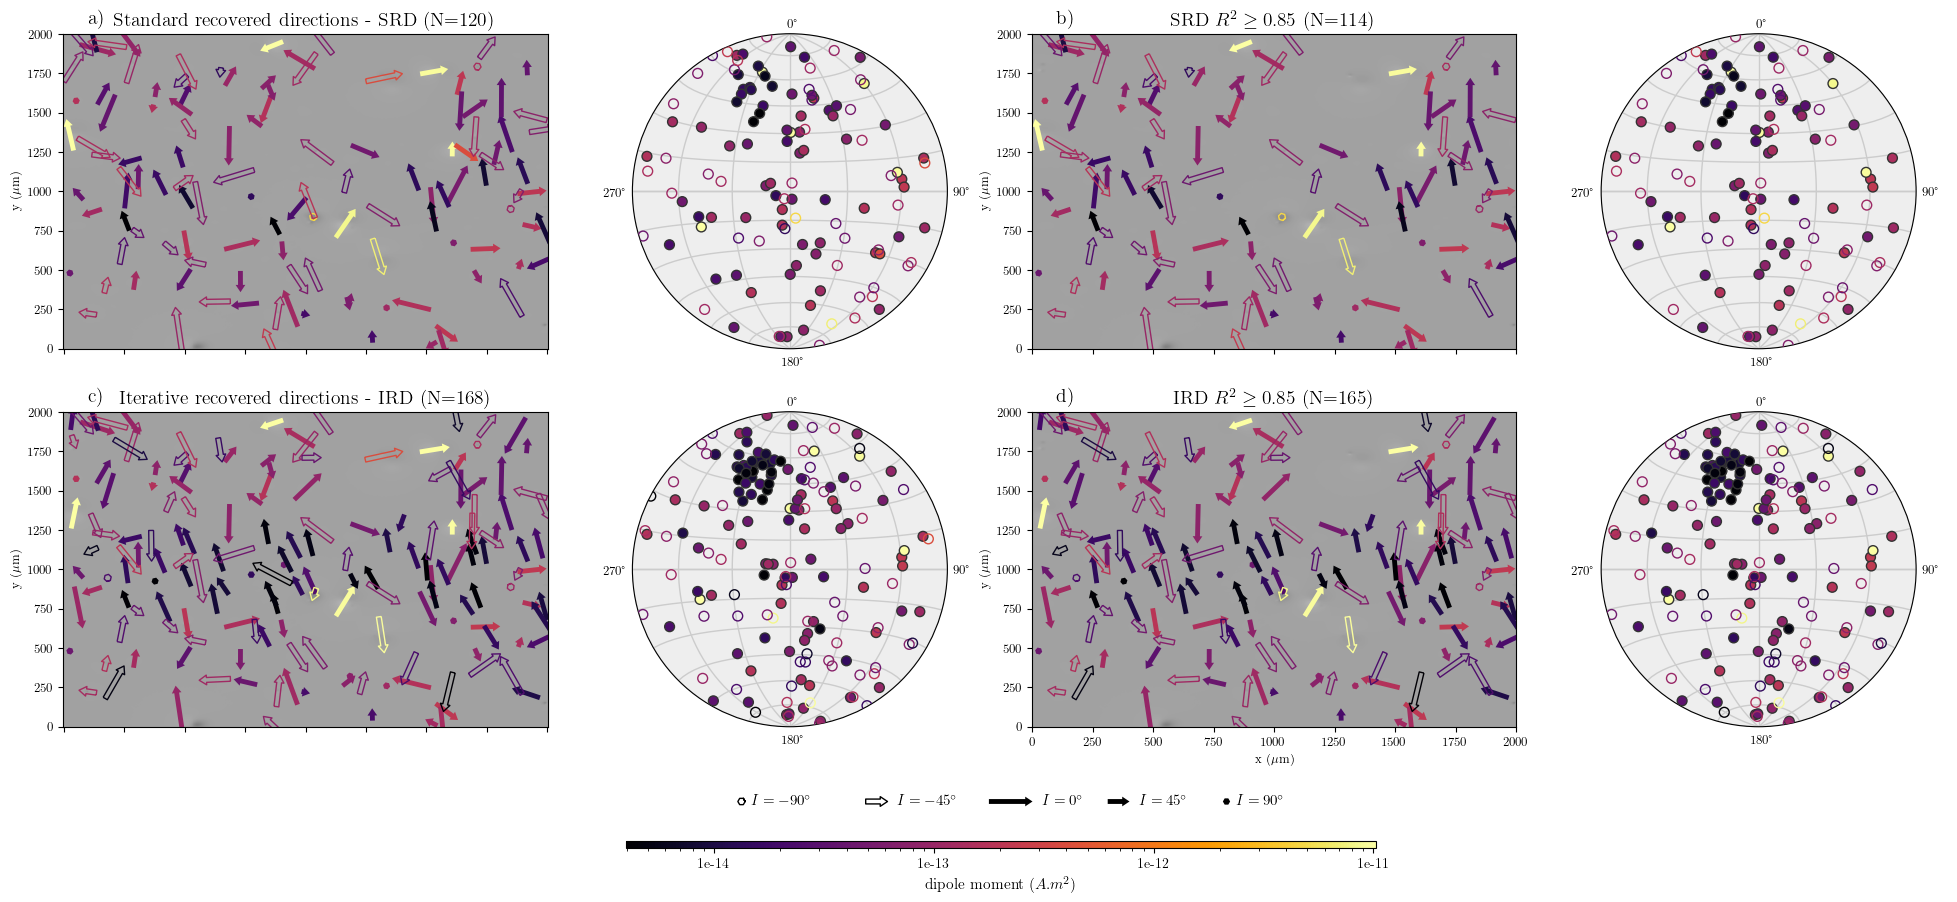

In [112]:
import warnings
warnings.filterwarnings('ignore')

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions_itr_enhanced)[0][pos_filter], 
                                  np.array(positions_itr_enhanced)[1][pos_filter], 
                                  np.array(positions_itr_enhanced)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler_enhanced, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler_enhanced).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq 0.85$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq 0.85$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    fig.savefig(fig_dir / "synthetic-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

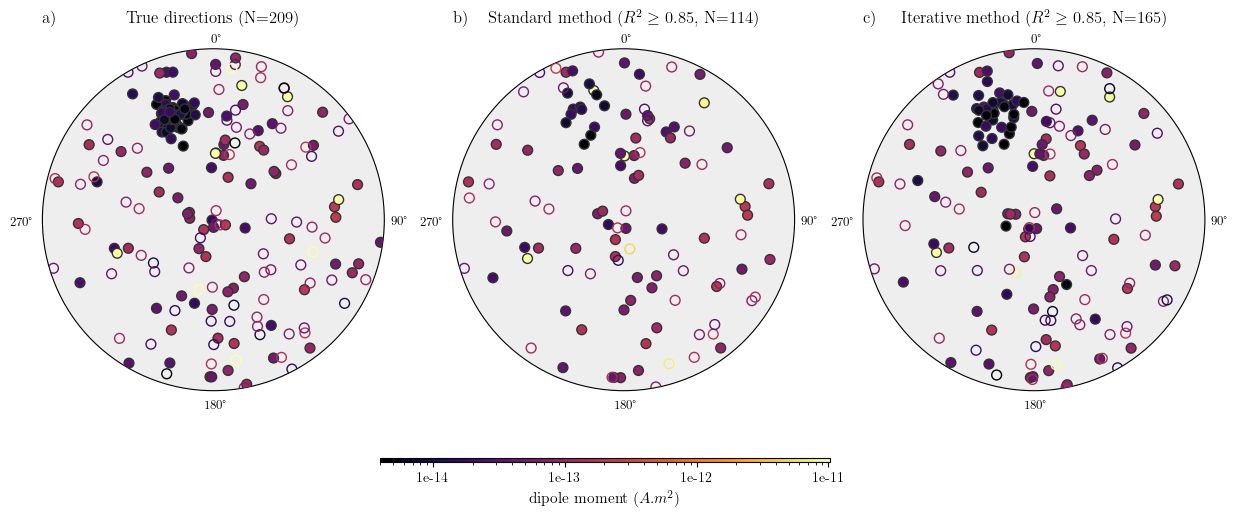

In [113]:
import warnings
warnings.filterwarnings('ignore')

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(15, 5))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, 0.01, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    N1 = dipole_moments.shape[0]
    ax = fig.add_subplot(1, 3, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm
    )    
    tmp = mg.plot_stereonet(dipole_moments, marker="o", zorder=1000, **kwargs, add_ticks=True)  

    #2
    N2 = filter_estimated_d_m.shape[0]
    ax = fig.add_subplot(1, 3, 2, projection='stereonet')
    axes.append(ax) 
    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)
    
    #3
    N3 = filter_estimated_d_m_itr.shape[0]
    ax = fig.add_subplot(1, 3, 3, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    
    titles = (f'True directions  (N={N1})'+'\n', 
              f'Standard method  ($R^2 \geq 0.85$, N={N2})'+'\n',
              f'Iterative method ($R^2 \geq 0.85$, N={N3})'+'\n')

    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.0, 1.0775, f"{letter})", transform=ax.transAxes, fontsize=12)
        ax.set_title(title, fontsize=12)
        ax.grid(False)
        # ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.2, hspace=0.0)
    fig.savefig(fig_dir / "synthetic-data-stereograms-comparison.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

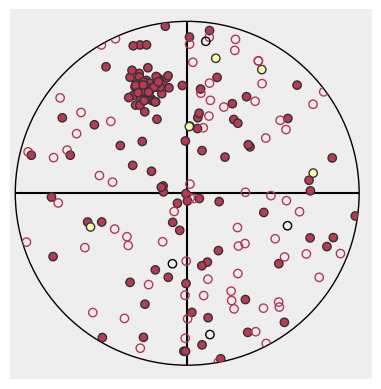

In [114]:
import numpy as np
import matplotlib.pyplot as plt

def equal_area_projection(vectors):
    # Calculate the unitary vector
    norm = np.linalg.norm(vectors, axis=1)
    
    vectors_unitary = np.zeros_like(vectors)
    vectors_unitary[:,0] = vectors[:,0]/norm
    vectors_unitary[:,1] = vectors[:,1]/norm
    vectors_unitary[:,2] = vectors[:,2]/norm

    inclinations, declinations, amplitudes = mg.vector_to_angles(vectors) 
          
    XY_projected = np.zeros( (len(vectors),3) )
    for i, projected_vector in enumerate(vectors_unitary):
        
        r = np.sqrt(1-np.abs(vectors_unitary[i,2]))/np.sqrt(vectors_unitary[i,0]**2+vectors_unitary[i,1]**2)
        
        XY_projected[i, 0] = r*vectors_unitary[i,1]
        XY_projected[i, 1] = r*vectors_unitary[i,0]

        if inclinations[i] >= 0:
            XY_projected[i, 2] = amplitudes[i]
        else:
            XY_projected[i, 2] = -amplitudes[i]

    return XY_projected

def plot_stereographic_projection(vectors, ax=None, cmap="inferno", cmap_norm=plt.Normalize, vmin=None, vmax=None, label=""):
    """
    Função que desenha a projeção estereográfica de Schmidt, com grande círculo e cruz no centro,
    e plota o ponto projetado de acordo com o mergulho e o rumo.
    
    Parameters:
    plunge (float): O mergulho do ponto a ser plotado em graus.
    bearing (float): O rumo do ponto a ser plotado em graus.
    """
    # Criar uma nova figura e eixo
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        
    facecolor = ax.set_facecolor("#eeeeee") # color "#eeeeee"
    ax.grid(linestyle="-", color="#cccccc", linewidth=1)
    
    # Desenhar o grande círculo (bordas da projeção)
    circle = plt.Circle((0, 0), 1, color='black', fill=False)
    clip_path = plt.Circle((0, 0), 1, transform=ax.transData)
    ax.add_artist(circle)
    
    # Desenhar a cruz no centro
    hline = ax.axhline(y=0, xmin=-1, xmax=1, color='black', zorder=-1)
    hline.set_clip_path(clip_path)
    vline = ax.axvline(x=0, ymin=-1, ymax=1, color='black', zorder=-1)
    vline.set_clip_path(clip_path)
    # Realizar a projeção estereográfica de Schmidt
    XY_projected = equal_area_projection(vectors)


    # Generate colors based on the amplitude values
    norm = cmap_norm(vmin=vmin, vmax=vmax)
    colors = plt.colormaps[cmap](norm(XY_projected[:,2]))
    
    # Plotar o ponto projetado
    positive_inc = XY_projected[:,2]>0
    scatter = ax.scatter(XY_projected[:,1][positive_inc],  XY_projected[:,0][positive_inc], 
                         c=colors[positive_inc],
                         label=f"{label}$I > 0$",
                         edgecolors="#333333",)
                         # **kwargs)
    scatter.set_clip_path(clip_path)
    scatter = ax.scatter(XY_projected[:,1][~positive_inc], XY_projected[:,0][~positive_inc],
                        c="#ffffff00",
                        label=f"{label}$I \le 0$",
                        edgecolors=colors[~positive_inc],)
                        # **kwargs)
    scatter.set_clip_path(clip_path)
    
    # Configurar a escala e os limites dos eixos
    ax.set_aspect('equal')
    
    # Remover os eixos
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_clip_path(clip_path)
    for spine in ax.spines.values():
        spine.set_visible(False)

    mappable = plt.cm.ScalarMappable(norm, cmap=cmap)
    return mappable

# Exemplo de uso
plot_stereographic_projection(dipole_moments)


In [115]:
def plot_stereographic_projection(vectors, ax=None, cmap="inferno", cmap_norm=plt.Normalize, vmin=None, vmax=None, label="", **kwargs):
    """
    Função que desenha a projeção estereográfica de Schmidt, com grande círculo e cruz no centro,
    e plota o ponto projetado de acordo com o mergulho e o rumo.
    """
    # Create new figure and axis
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

    # Add a face color
    background_circle = plt.Circle((0, 0), 1, color="#eeeeee", zorder=-2)  # zorder para colocar atrás dos pontos
    ax.add_artist(background_circle)

    # Draw the great circle
    circle = plt.Circle((0, 0), 1, color='black', fill=False, zorder=3)
    ax.add_artist(circle)
    
    # Define the clipping area
    clip_path = plt.Circle((0, 0), 1, transform=ax.transData)
    
    # Draw the central cross
    hline = ax.axhline(y=0, color='black', zorder=-1)
    hline.set_clip_path(clip_path)
    vline = ax.axvline(x=0, color='black', zorder=-1)
    vline.set_clip_path(clip_path)
    
    # Calculate the equal area projection
    XY_projected = equal_area_projection(vectors)

    # Genearte colors based on the amplitude values
    norm = cmap_norm(vmin=vmin, vmax=vmax)
    colors = plt.colormaps[cmap](norm(abs(XY_projected[:, 2])))
    
    # Plotting the data
    positive_inc = XY_projected[:, 2] > 0
    scatter_pos = ax.scatter(XY_projected[:, 1][positive_inc], XY_projected[:, 0][positive_inc], 
                             c=colors[positive_inc], edgecolors="#333333", label=f"{label}$I > 0$",
                            **kwargs)
    scatter_pos.set_clip_path(clip_path)
    
    scatter_neg = ax.scatter(XY_projected[:, 1][~positive_inc], XY_projected[:, 0][~positive_inc],
                             c="#ffffff00", edgecolors=colors[~positive_inc], label=f"{label}$I \le 0$",
                            **kwargs)
    scatter_neg.set_clip_path(clip_path)
    
    # Configure the axis
    ax.set_aspect('equal')
    
    # Remove axes and box
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # colormap (if necessary)
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    return mappable


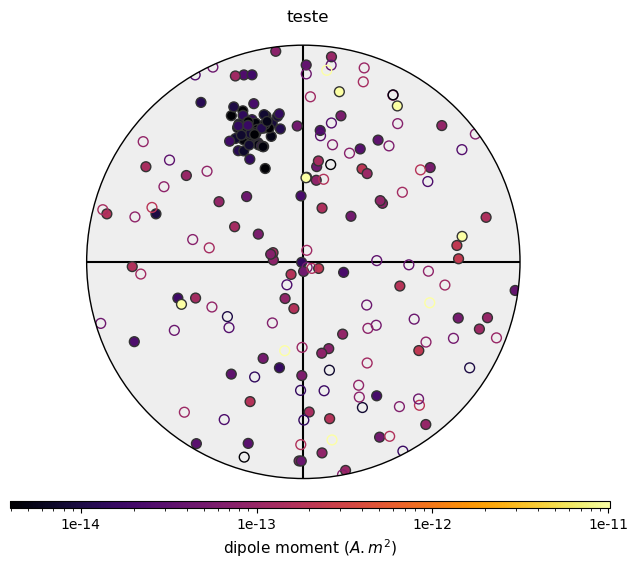

In [116]:
kwargs = dict(
    vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm
)   


fig = plt.figure(figsize=(20, 10))
axes = []

ax = fig.add_subplot(1, 3, 1)
axes.append(ax)  
tmp = plot_stereographic_projection(dipole_moments, ax=ax, **kwargs)
clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.09, 0.25, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
clb.ax.tick_params(labelsize=10)
ax.set_title('teste')
plt.show()


In [117]:
import numpy as np
import matplotlib.pyplot as plt

class StereographicProjection:
    def __init__(self, vectors):
        self.vectors = vectors

    def vector_to_angles(self, vector):
        """
        Generate inclination, declination, and amplitude from a 3-component vector

        Inclination is positive downwards and declination is the angle with the y
        component. The vector has x, y, and z (upward) Cartesian components.

        Parameters
        ----------
        vector : 1D or 2D array
            The x, y, z vector components. Can be a 1D array for a single vector
            or 2D for multiple. If 2D, then each vector should be a row of the
            array.

        Returns
        -------
        inclination : float or array
            The inclination values in degrees.
        declination : float or array
            The declination values in degrees.
        amplitude : float or array
            The vector amplitude values.
        """
        vector = np.asarray(vector)
        x, y, z = vector.T
        amplitude = np.sqrt(x**2 + y**2 + z**2)
        inclination = -np.degrees(np.arctan2(z, np.hypot(x, y)))
        declination = np.degrees(np.arctan2(x, y))
        return inclination, declination, amplitude

    def angles_to_vector(self, inclination, declination, amplitude):
        """
        Generate a 3-component vector from inclination, declination, and amplitude

        Inclination is positive downwards and declination is the angle with the y
        component. The vector has x, y, and z (upward) Cartesian components.

        Parameters
        ----------
        inclination : float or array
            The inclination values in degrees.
        declination : float or array
            The declination values in degrees.
        amplitude : float or array
            The vector amplitude values.

        Returns
        -------
        vector : 1D or 2D array
            The calculated x, y, z vector components. 1D if it's a single vector.
            If N vectors are calculated, the "vector" will have shape (N, 3) with
            each vector in a row of the array.
        """
        inclination = np.radians(inclination)
        declination = np.radians(declination)
        amplitude = np.asarray(amplitude)
        sin_inc = np.sin(-inclination)
        cos_inc = np.cos(-inclination)
        sin_dec = np.sin(declination)
        cos_dec = np.cos(declination)
        x = cos_inc * sin_dec * amplitude
        y = cos_inc * cos_dec * amplitude
        z = sin_inc * amplitude
        return np.transpose([x, y, z])

    def equal_area_projection(self):
        norm = np.linalg.norm(self.vectors, axis=1)
        vectors_unitary = self.vectors / norm[:, np.newaxis]
        inclinations, declinations, amplitudes = self.vector_to_angles(self.vectors)

        XY_projected = np.zeros((len(self.vectors), 3))
        for i, projected_vector in enumerate(vectors_unitary):
            r = np.sqrt(1 - np.abs(vectors_unitary[i, 2])) / np.sqrt(vectors_unitary[i, 0]**2 + vectors_unitary[i, 1]**2)
            XY_projected[i, 0] = r * vectors_unitary[i, 1]
            XY_projected[i, 1] = r * vectors_unitary[i, 0]
            XY_projected[i, 2] = amplitudes[i] if inclinations[i] >= 0 else -amplitudes[i]

        return XY_projected

    def plot(self, ax=None, cmap="inferno", cmap_norm=plt.Normalize, vmin=None, vmax=None, 
             label="", s=50, draw_cross=True, add_radial_grid=True,
             **kwargs):
        """
        Draw the stereographic projection, with optional central cross.
        """
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)

        # Add a face color
        background_circle = plt.Circle((0, 0), 1, color="#eeeeee", zorder=-2)
        ax.add_artist(background_circle)

        # Draw the great circle
        circle = plt.Circle((0, 0), 1, color='black', fill=False, zorder=3)
        ax.add_artist(circle)

        # Define the clipping area
        clip_path = plt.Circle((0, 0), 1, transform=ax.transData)

        # Draw the central cross if requested
        if draw_cross:
            hline = ax.axhline(y=0, color='black', zorder=-1)
            hline.set_clip_path(clip_path)
            vline = ax.axvline(x=0, color='black', zorder=-1)
            vline.set_clip_path(clip_path)


        # Draw the radial grid if requested
        if add_radial_grid:
            for rad_dec in range(0, 360, 10):  # Grid lines every 15 degrees
                rad_inc = np.linspace(0, 85, 90)  # Inclinations from 0 to 90 degrees
                rad_int = np.ones_like(rad_inc)  # Constant amplitude for the grid lines

                # Generate the radial vectors
                radial_vector = self.angles_to_vector(rad_inc, rad_dec, rad_int)

                # Project the radial vectors
                radial_projected = equal_area_projection(radial_vector)

                # Plot each radial grid line
                ax.plot(radial_projected[:, 1], radial_projected[:, 0], color='gray', zorder=-1, lw=0.5)
            for circ_inc in range(0, 90, 10):
                circ_dec = np.linspace(0, 360)  # Inclinations from 0 to 90 degrees
                circ_int = np.ones_like(circ_dec)  # Constant amplitude for the grid lines

                # Generate the radial vectors
                circle_vector = self.angles_to_vector(circ_inc, circ_dec, circ_int)
                # Project the radial vectors
                circle_projected = equal_area_projection(circle_vector)

                # Plot each radial grid line
                ax.plot(circle_projected[:, 1], circle_projected[:, 0], color='gray', zorder=-1, lw=0.5)
        
        # Calculate the equal area projection
        XY_projected = self.equal_area_projection()

        # Generate colors based on the amplitude values
        norm = cmap_norm(vmin=vmin, vmax=vmax)
        colors = plt.colormaps[cmap](norm(abs(XY_projected[:, 2])))

        # Plotting the data
        positive_inc = XY_projected[:, 2] > 0
        scatter_pos = ax.scatter(XY_projected[:, 1][positive_inc], XY_projected[:, 0][positive_inc], 
                                 c=colors[positive_inc], edgecolors="#333333", label=f"{label}$I > 0$",
                                **kwargs)
        scatter_pos.set_clip_path(clip_path)

        scatter_neg = ax.scatter(XY_projected[:, 1][~positive_inc], XY_projected[:, 0][~positive_inc],
                                 c="#ffffff00", edgecolors=colors[~positive_inc], label=f"{label}$I \le 0$",
                                **kwargs)
        scatter_neg.set_clip_path(clip_path)

        # Configure the axis
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

        # Colormap (if necessary)
        mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        return mappable


In [118]:
import numpy as np
import matplotlib.pyplot as plt

def vector_to_angles(vector):
    """
    Generate inclination, declination, and amplitude from a 3-component vector

    Inclination is positive downwards and declination is the angle with the y
    component. The vector has x, y, and z (upward) Cartesian components.

    Parameters
    ----------
    vector : 1D or 2D array
        The x, y, z vector components. Can be a 1D array for a single vector
        or 2D for multiple. If 2D, then each vector should be a row of the
        array.

    Returns
    -------
    inclination : float or array
        The inclination values in degrees.
    declination : float or array
        The declination values in degrees.
    amplitude : float or array
        The vector amplitude values.
    """
    vector = np.asarray(vector)
    x, y, z = vector.T
    amplitude = np.sqrt(x**2 + y**2 + z**2)
    inclination = -np.degrees(np.arctan2(z, np.hypot(x, y)))
    declination = np.degrees(np.arctan2(x, y))
    return inclination, declination, amplitude

def angles_to_vector(inclination, declination, amplitude):
    """
    Generate a 3-component vector from inclination, declination, and amplitude

    Inclination is positive downwards and declination is the angle with the y
    component. The vector has x, y, and z (upward) Cartesian components.

    Parameters
    ----------
    inclination : float or array
        The inclination values in degrees.
    declination : float or array
        The declination values in degrees.
    amplitude : float or array
        The vector amplitude values.

    Returns
    -------
    vector : 1D or 2D array
        The calculated x, y, z vector components. 1D if it's a single vector.
        If N vectors are calculated, the "vector" will have shape (N, 3) with
        each vector in a row of the array.
    """
    inclination = np.radians(inclination)
    declination = np.radians(declination)
    amplitude = np.asarray(amplitude)
    sin_inc = np.sin(-inclination)
    cos_inc = np.cos(-inclination)
    sin_dec = np.sin(declination)
    cos_dec = np.cos(declination)
    x = cos_inc * sin_dec * amplitude
    y = cos_inc * cos_dec * amplitude
    z = sin_inc * amplitude
    return np.transpose([x, y, z])

def equal_area_projection(vectors):
    norm = np.linalg.norm(vectors, axis=1)
    vectors_unitary = vectors / norm[:, np.newaxis]
    inclinations, declinations, amplitudes = vector_to_angles(vectors)

    XY_projected = np.zeros((len(vectors), 3))
    for i, projected_vector in enumerate(vectors_unitary):
        r = np.sqrt(1 - np.abs(vectors_unitary[i, 2])) / np.sqrt(vectors_unitary[i, 0]**2 + vectors_unitary[i, 1]**2)
        XY_projected[i, 0] = r * vectors_unitary[i, 1]
        XY_projected[i, 1] = r * vectors_unitary[i, 0]
        XY_projected[i, 2] = amplitudes[i] if inclinations[i] >= 0 else -amplitudes[i]

    return XY_projected



class StereographicProjection:
    def __init__(self, vectors):
        self.vectors = vectors

    def plot(self, ax=None, cmap="inferno", cmap_norm=plt.Normalize, vmin=None, vmax=None, 
             label="", 
             # s=50, 
             add_ticks=True, draw_cross=True, add_radial_grid=True, 
             facecolor="#ffffff00", add_legend=False,
             **kwargs):
        """
        Draw the stereographic projection
        """
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)

        # Add a face color
        background_circle = plt.Circle((0, 0), 1, color=facecolor, zorder=-2)
        ax.add_artist(background_circle)

        # Draw the great circle
        circle = plt.Circle((0, 0), 1, color='black', fill=False, zorder=3)
        ax.add_artist(circle)

        # Define the clipping area
        clip_path = plt.Circle((0, 0), 1, transform=ax.transData)

        if add_ticks:
            # Add ticks 
            ax.text(-0.025, 1.05, '0°')
            ax.text(-0.05, -1.075, '180°')
            ax.text(-1.15, -0.025, '270°')
            ax.text(1.025, -0.025, '90°')
        
        if label and not label.endswith(" "):
            label = label + " "
            # Draw the central cross if requested
            if draw_cross:
                hline = ax.axhline(y=0, color='black', zorder=-1)
                hline.set_clip_path(clip_path)
                vline = ax.axvline(x=0, color='black', zorder=-1)
                vline.set_clip_path(clip_path)


        # Draw the radial grid
        if add_radial_grid:
            for rad_dec in range(0, 360, 10):  # Grid lines every 10 degrees
                rad_inc = np.linspace(0, 90, 1000)  # Inclinations from 0 to 90 degrees
                # rad_int = np.ones_like(rad_inc)  # Constant amplitude for the grid lines

                # Generate the radial vectors
                radial_vector = angles_to_vector(rad_inc, rad_dec, 1)

                # Project the radial vectors
                radial_projected = equal_area_projection(radial_vector)

                # Plot each radial grid line
                ax.plot(radial_projected[:, 1], radial_projected[:, 0], color='gray', zorder=-2, lw=0.5)
            for circ_inc in range(0, 90, 10):
                circ_dec = np.linspace(0, 360, 1000)  # Inclinations from 0 to 90 degrees
                circ_int = np.ones_like(circ_dec)  # Constant amplitude for the grid lines

                # Generate the radial vectors
                circle_vector = angles_to_vector(circ_inc, circ_dec, circ_int)
                # Project the radial vectors
                circle_projected = equal_area_projection(circle_vector)

                # Plot each radial grid line
                ax.plot(circle_projected[:, 1], circle_projected[:, 0], color='gray', zorder=-2, lw=0.5)
        
        # Calculate the equal area projection
        XY_projected = equal_area_projection(self.vectors)

        # Generate colors based on the amplitude values
        norm = cmap_norm(vmin=vmin, vmax=vmax)
        colors = plt.colormaps[cmap](norm(abs(XY_projected[:, 2])))

        # Plotting the data
        positive_inc = XY_projected[:, 2] > 0
        scatter_pos = ax.scatter(XY_projected[:, 1][positive_inc], XY_projected[:, 0][positive_inc], 
                                 c=colors[positive_inc], edgecolors="#333333", label=f"{label}$I > 0$",
                                **kwargs)
        scatter_pos.set_clip_path(clip_path)

        scatter_neg = ax.scatter(XY_projected[:, 1][~positive_inc], XY_projected[:, 0][~positive_inc],
                                 c="#ffffff00", edgecolors=colors[~positive_inc], label=rf"{label}$I \leq 0$",
                                **kwargs)
        scatter_neg.set_clip_path(clip_path)

        # Configure the axis
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        if add_legend:
            ax.legend()
        for spine in ax.spines.values():
            spine.set_visible(False)

        # Colormap (if necessary)
        mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        return mappable


In [119]:
filter = mg.vector_to_angles(dipole_moments)[2]<=1.0e-13

test = np.sum(dipole_moments[filter], axis=0)
test_ang = mg.vector_to_angles(test)
test_ang

(42.01560467745444, 30.60294163927875, 7.540608318007789e-13)

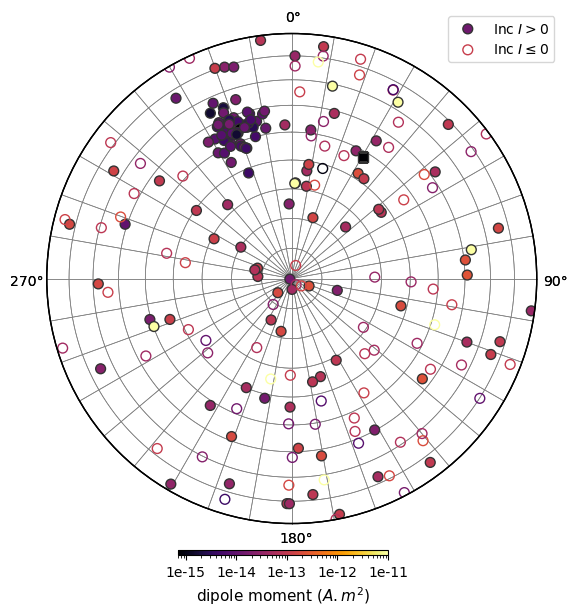

In [120]:
projection = mg.StereographicProjection(dipole_moments)
projection_R = mg.StereographicProjection(np.reshape(test,(1,3)))


kwargs = dict(
    s=50, cmap=cmap, cmap_norm=cmap_norm
)   

# Plota a projeção estereográfica
fig, ax = plt.subplots(figsize=(7,7))
tmp = projection.plot(ax=ax, draw_cross=False, add_radial_grid=True, label="Inc", add_legend=True, **kwargs)
tmp_R = projection_R.plot(ax=ax, marker='s', **kwargs)
clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, 0.1, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
clb.ax.tick_params(labelsize=10)
plt.show()

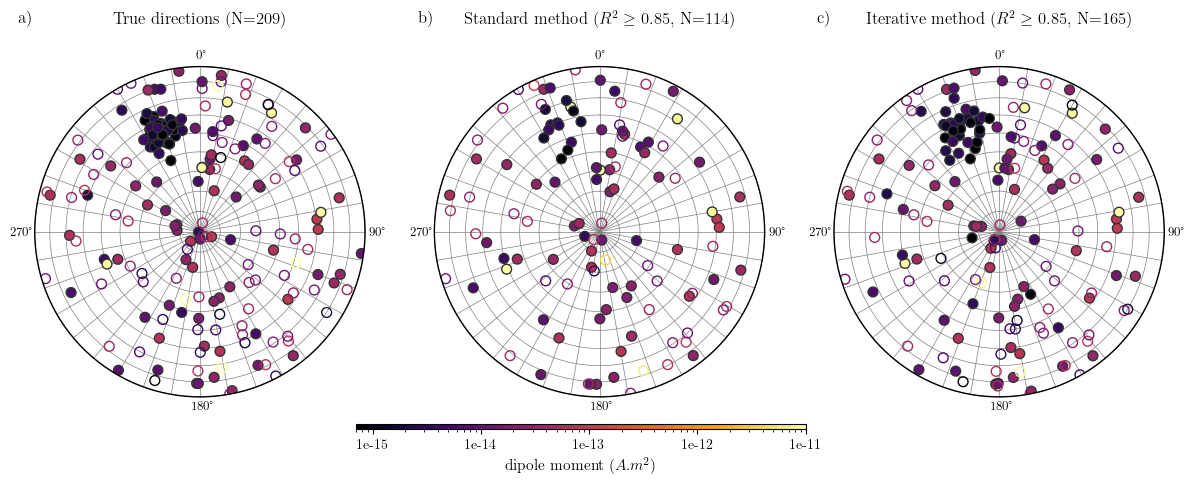

In [121]:
import warnings
warnings.filterwarnings('ignore')

vmin = np.min(estimated)
vmax = np.max(estimated)
cmap = "inferno"
# Use matplotlib.colors.LogNorm for a log scale
cmap_norm = matplotlib.colors.LogNorm #Normalize

kwargs = dict(
    ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm
)    

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(15, 5))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, 0.1, 0.3, 0.01]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    N1 = dipole_moments.shape[0]
    ax = fig.add_subplot(1, 3, 1)
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm
    )    

    projection = StereographicProjection(dipole_moments)
    tmp = projection.plot(draw_cross=True, add_radial_grid=True, **kwargs)

    #2
    N2 = filter_estimated_d_m.shape[0]
    ax = fig.add_subplot(1, 3, 2)
    axes.append(ax) 
    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    projection = StereographicProjection(filter_estimated_d_m)
    tmp = projection.plot(draw_cross=True, add_radial_grid=True, **kwargs)
    
    #3
    N3 = filter_estimated_d_m_itr.shape[0]
    ax = fig.add_subplot(1, 3, 3)
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm
    )    
    projection = StereographicProjection(filter_estimated_d_m_itr)
    tmp = projection.plot(draw_cross=True, add_radial_grid=True, **kwargs)
    
    titles = (f'True directions  (N={N1})'+'\n', 
              f'Standard method  ($R^2 \geq 0.85$, N={N2})'+'\n',
              f'Iterative method ($R^2 \geq 0.85$, N={N3})'+'\n')

    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.0, 1.0775, f"{letter})", transform=ax.transAxes, fontsize=12)
        ax.set_title(title, fontsize=12)
        ax.grid(False)
        # ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.1, hspace=0.0)
    fig.savefig(fig_dir / "synthetic-data-stereograms-comparison.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

In [122]:
teste = angles_to_vector([0, 0, 0, 0], [0, 90, 180, 270], [1,1,1,1])
np.round(teste)

array([[ 0.,  1., -0.],
       [ 1.,  0., -0.],
       [ 0., -1., -0.],
       [-1., -0., -0.]])

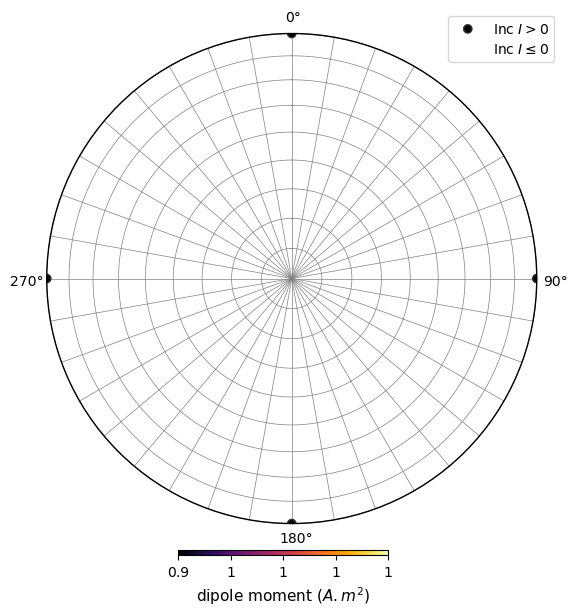

In [123]:
projection = StereographicProjection(teste)

# Plota a projeção estereográfica
fig, ax = plt.subplots(figsize=(7,7))
aaa = projection.plot(ax=ax, draw_cross=False, add_radial_grid=True, label="Inc", add_legend=True)
clb = fig.colorbar(
        aaa, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, 0.1, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
clb.ax.tick_params(labelsize=10)
plt.show()